In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
import os
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter

In [3]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) # TODO this is probably a bit wrong
    return angle, angle_unwrapped

def get_cumulative_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    return frame_distances.cumsum()  # This gives total distance traveled over time

def get_displacement(data):
    x_displacement = (data['centroid_x'] - data['centroid_x'].iloc[0]) * 1/PIX_PER_MM
    y_displacement = (data['centroid_y'] - data['centroid_y'].iloc[0]) * 1/PIX_PER_MM
    return np.sqrt(x_displacement**2 + y_displacement**2)

class StimType(IntEnum):
    DARK = 0
    BRIGHT = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5

def get_cumulative_speed(data):
    # For frame-to-frame calculations, each time step is 1 unit
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    speed = frame_distances/ get_relative_time(data).diff()  # distance per frame
    return speed


In [4]:
def smooth_data(speed_data, method='gaussian', **kwargs):
    # Convert to pandas Series if not already
    data = pd.Series(speed_data)
    
    if method == 'gaussian':
        # Default parameters
        sigma = kwargs.get('sigma', 2)
        
        # Create a copy to avoid modifying the original
        smoothed = data.copy()
    
        # Apply Gaussian filter to data and mask
        smoothed = gaussian_filter1d(data.values, sigma=sigma)
        
    elif method == 'moving_avg':
        # Default parameters
        window = kwargs.get('window', 15)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply rolling window average
        smoothed = data.rolling(
            window=window, 
            center=True, 
            min_periods=min_periods
        ).mean()
        
    elif method == 'ewm':
        # Default parameters
        span = kwargs.get('span', 10)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply exponentially weighted moving average
        smoothed = data.ewm(
            span=span, 
            min_periods=min_periods
        ).mean()
    
    else:
        raise ValueError(f"Unknown smoothing method: {method}")
        
    return smoothed
def detect_fish_bouts_2(data, fish_id=None, method='gaussian', **kwargs):
    """
    Process fish movement data to detect swimming bouts
    
    Parameters:
    - data: DataFrame containing fish movement data
    - fish_id: Optional ID for the fish (for plot titles)
    - method: Smoothing method to use ('gaussian', 'moving_avg', 'ewm')
    - kwargs: Additional parameters for the smoothing method
    
    Returns:
    - DataFrame containing bout information
    """
    # Make a copy to avoid modifying the original data
    df = data.copy()
    
    smoothed_speed = smooth_data(df['speed'], method=method, **kwargs)
    df['smoothed_speed'] = smoothed_speed
    
    # Calculate threshold for bout detection
    mean_speed = np.mean(smoothed_speed)
    std_speed = np.std(smoothed_speed)
    threshold = mean_speed + 2 * std_speed
    
    # Find peaks in the smoothed data (potential bout centers)
    peaks, peak_properties = find_peaks(
        smoothed_speed, 
        height=threshold,
        distance=10,  # Minimum samples between peaks
        prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
    )
    
    # Find regions where speed exceeds threshold (bout regions)
    bout_indices = np.where(smoothed_speed > threshold)[0]
    
    # Group consecutive indices to identify complete bouts
    bout_groups = []
    for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 3:  # Minimum number of frames to be considered a bout
            bout_groups.append((group[0], group[-1]))
    
    # Track the number of bouts detected
    num_bouts_detected = len(bout_groups)
    # Create a DataFrame to store bout information
    bout_info = []
    for i, (start_idx, end_idx) in enumerate(bout_groups):
        # Find the peak within this bout
        bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
        if bout_peaks:
            peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
            peak_speed = smoothed_speed[peak_idx]
            
            # Calculate angle change
            angle_before_bout = np.unwrap(df['angle'].iloc[max(0, start_idx-1):start_idx+1])
            angle_after_bout = np.unwrap(df['angle'].iloc[end_idx:end_idx+2])
            angle_change = angle_after_bout[-1] - angle_before_bout[0]

            # Calculate mean distance traveled during the bout
            distance_during_bout = df['distance'].iloc[start_idx:end_idx+1].mean()
            
            #number of bouts detected

            # Calculate bout properties
            bout_info.append({
                'fish_id': fish_id,
                'bout_id': i+1,
                'start_idx': start_idx,
                'peak_idx': peak_idx,
                'end_idx': end_idx,
                'start_time': df['relative_time'].iloc[start_idx],
                'peak_time': df['relative_time'].iloc[peak_idx],
                'end_time': df['relative_time'].iloc[end_idx],
                'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
                'peak_speed': peak_speed,
                'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1]),
                'angle_change': angle_change,
                'distance_during_bout': distance_during_bout,  # distance traveled during the bout
                'num_bouts_detected': num_bouts_detected
            })
    
    bout_df = pd.DataFrame(bout_info)
    
    # Calculate inter-bout intervals
    bout_df['inter_bout_interval'] = bout_df['start_time'].diff().shift(-1)
    
    return bout_df  

def plot_bout_detection(df, bout_df, fish_id):
    """
    Create plots to visualize the bout detection process
    
    Parameters:
    - df: DataFrame containing the processed data
    - bout_df: DataFrame containing bout information
    - fish_id: ID for the fish (for plot titles)
    """
    smoothed_speed = df['smoothed_speed']
    threshold = np.mean(smoothed_speed) + 2 * np.std(smoothed_speed)
    peaks = bout_df['peak_idx'].values
    bout_groups = bout_df[['start_idx', 'end_idx']].values
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Original vs Smoothed Speed
    ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
    ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
    ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    ax1.set_ylabel('Speed (mm/sec)')
    ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Detected Bouts
    ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
    ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
    # Highlight bout regions
    for start_idx, end_idx in bout_groups:
        start_time = df['relative_time'].iloc[start_idx]
        end_time = df['relative_time'].iloc[end_idx]
        ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
    # Mark peak points
    peak_times = df['relative_time'].iloc[peaks]
    peak_speeds = smoothed_speed.iloc[peaks]
    ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
    ax2.set_xlabel('Relative Time')
    ax2.set_ylabel('Speed (mm/sec)')
    ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_bout_statistics(bout_df, fish_id):
    # ...existing code...
    
    if len(bout_df) > 0:
        print(f"Total Number of bouts detected: {bout_df['num_bouts_detected'].iloc[0]}")
        print(f"Average bout duration: {bout_df['duration'].mean():.2f} time units")
        print(f"Average bout peak speed: {bout_df['peak_speed'].mean():.2f} mm/sec")
        print(f"Average bout mean speed: {bout_df['mean_speed'].mean():.2f} mm/sec")
        print(f"Average inter-bout interval: {bout_df['inter_bout_interval'].mean():.2f} time units")
        print(f"Average angle change: {bout_df['angle_change'].mean():.2f} radians")
        print(f"Average distance traveled: {bout_df['distance_during_bout'].mean():.2f} mm") 
        print("\nTop 5 bouts by peak speed:")
        print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])

def plot_histograms(bout_df, bins):
    """
    Plot histograms of bout duration, inter-bout intervals (log-normal scale), and angle change.
    
    Parameters:
    - bout_df: DataFrame containing bout information
    """
    plt.figure(figsize=(20, 5))
    
    # Plot histogram of bout duration
    plt.subplot(1, 3, 1)
    plt.hist(bout_df['duration'], bins=bins, color='blue', alpha=0.7)
    plt.title('Bout Duration')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    
    
    # Plot histogram of inter-bout intervals (log-transformed but displayed in original units)
    plt.subplot(1, 3, 2)
    log_intervals = bout_df['log_inter_bout_interval'].dropna()  # Use the precomputed log-transformed column
    plt.hist(log_intervals, bins=bins, color='green', alpha=0.7)
    
    # Adjust x-axis ticks to show original units
    original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
    plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
    
    plt.title('Inter-Bout Intervals (Log-Transformed)')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    
    # Plot histogram of angle change
    plt.subplot(1, 3, 3)
    plt.hist(bout_df['angle_change'], bins=bins, color='red', alpha=0.7)
    plt.title('Angle Change')
    plt.xlabel('Angle Change (radians)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of distance traveled
    plt.subplot(2, 2, 4)
    plt.hist(bout_df['distance_during_bout'], bins=bins, color='purple', alpha=0.7)
    plt.title('Distance Traveled During Bouts')
    plt.xlabel('Distance (mm)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of mean speed during bouts
    plt.subplot(2, 3, 5)
    plt.hist(bout_df['mean_speed'], bins=bins, color='orange', alpha=0.7)
    plt.title('Mean Speed During Bouts')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    # Plot histogram of peak speed during bouts
    plt.subplot(2, 3, 6)
    plt.hist(bout_df['peak_speed'], bins=bins, color='cyan', alpha=0.7)
    plt.title('Peak Speed During Bouts')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [131]:
def plot_trajectory(derived_metrics_df, fish_id):
    """
    Plot the trajectory of a fish based on its centroid positions.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure(figsize=(12, 6))
    plt.scatter(
        fish_data['centroid_x'] / PIX_PER_MM,
        fish_data['centroid_y'] / PIX_PER_MM,
        c=fish_data['relative_time'],
        cmap='viridis',
        s=20,
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        fish_data['centroid_x'] / PIX_PER_MM,
        fish_data['centroid_y'] / PIX_PER_MM,
        color='gray',
        linewidth=1.5,
        alpha=0.3
    )
    plt.show()


def plot_distance(derived_metrics_df, fish_id):
    """
    Plot the cumulative distance traveled by a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['distance'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()


def plot_speed(derived_metrics_df, fish_id):
    """
    Plot the speed of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['speed'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()


def plot_smoothed_speed(derived_metrics_df, fish_id):
    """
    Plot the smoothed speed of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['smoothed_speed'], label='Smoothed Speed (mm/sec)', color='orange')
    plt.title(f'Smoothed Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Smoothed Speed (mm/sec)')
    plt.legend()
    plt.show()


def plot_angle(derived_metrics_df, fish_id):
    """
    Plot the heading angle of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle (radians)')
    plt.yticks(
        ticks=[-np.pi, -np.pi/2, -3*np.pi/2, 0, np.pi/2, 3*np.pi/2, np.pi],
        labels=[r'$-\pi$', r'$-\pi/2$', r'$-3\pi/2$', '0', r'$\pi/2$', r'$3\pi/2$', r'$\pi$']
    )
    plt.legend()
    plt.show()


def plot_unwrapped_angle(derived_metrics_df, fish_id):
    """
    Plot the unwrapped heading angle of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(fish_data['relative_time'], fish_data['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle (radians)')
    plt.legend()
    plt.show()


def plot_all_metrics(derived_metrics_df, bout_properties_df, fish_id, bins):
    """
    Plot all metrics (trajectory, distance, speed, smoothed speed, angle, unwrapped angle)
    and print bout statistics for a specific fish ID.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - fish_id (int): ID of the fish to plot.
    """
    print(f"Plotting metrics and printing statistics for Fish ID: {fish_id}")
    
    # Print bout statistics
    fish_bout_data = bout_properties_df[bout_properties_df['fish_id'] == fish_id]
    print_bout_statistics(fish_bout_data, fish_id)
    
    # Call individual plotting functions
    plot_trajectory(derived_metrics_df, fish_id)
    plot_distance(derived_metrics_df, fish_id)
    plot_speed(derived_metrics_df, fish_id)
    plot_smoothed_speed(derived_metrics_df, fish_id)
    plot_angle(derived_metrics_df, fish_id)
    plot_unwrapped_angle(derived_metrics_df, fish_id)
    
    # Plot bout detection
    fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plot_bout_detection(fish_data, fish_bout_data, fish_id)
    plt.show()
    
    # Plot histograms of bout properties
    print(f"Histograms for Fish ID: {fish_id}")
    plot_histograms(fish_bout_data,bins)

In [ ]:
def calculate_derived_metrics(data, label, output_folder=r'.\processed_data'):
    """
    Detect swimming bouts from derived metrics and save the bout properties to a CSV file.


    Returns:
    - derived_metrics_df (pd.DataFrame): DataFrame containing swimming properties, including duration, peak speed, and angle change.
    """
    
    derived_metrics_list = []
    # Check if 'fish_id' exists
    grouped_df = data.groupby('fish_id')
    for fish_id, group in grouped_df:
        group['relative_time'] = get_relative_time(group)
        group['relative_index'] = get_relative_index(group)
        group['distance'] = get_cumulative_distance(group)
        group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
        group['speed'] = get_cumulative_speed(group)
        group['smoothed_speed'] = smooth_data(group['speed'], method='gaussian', sigma=2)
        derived_metrics_list.append(group)
    
    derived_metrics_df = pd.concat(derived_metrics_list, ignore_index=True)

    # Save derived metrics
    date_str = datetime.now().strftime('%Y%m%d')
    derived_metrics_path = os.path.join(output_folder, f'derived_metrics_{label}_{date_str}.csv')
    derived_metrics_df.to_csv(derived_metrics_path, index=False)
    print(f"Derived metrics saved to {derived_metrics_path}")

    return derived_metrics_df

In [ ]:
def filter_extreme_angle_changes(derived_df, fish_id=None, window_ms=200):
    """
    Filters out extreme changes in angle from the derived_df DataFrame.

    Parameters:
    - derived_df (pd.DataFrame): DataFrame containing 'angle' (in radians), 'relative_time' (in seconds), and 'fish_id'.
    - fish_id (int, optional): Specific fish_id to process. If None, process all fish.
    - window_ms (int): Window size in milliseconds for calculating the threshold (default: 200ms).

    Returns:
    - filtered_df (pd.DataFrame): DataFrame with extreme angle changes filtered out.
    """
    # Convert window size from milliseconds to seconds
    window_s = window_ms / 1000.0

    # If a specific fish_id is provided, filter the DataFrame
    if fish_id is not None:
        grouped = derived_df[derived_df['fish_id'] == fish_id].groupby('fish_id')
    else:
        grouped = derived_df.groupby('fish_id')

    # Initialize a list to store filtered data
    filtered_data = []

    # Process each fish_id group
    for fish_id, fish_data in grouped:
        fish_data = fish_data.copy()

        # Iterate over the DataFrame with a rolling window
        for i in range(len(fish_data)):
            # Define the start and end of the window
            start_time = fish_data['relative_time'].iloc[i]
            end_time = start_time + window_s

            # Get the rows within the window
            window_data = fish_data[
                (fish_data['relative_time'] >= start_time) &
                (fish_data['relative_time'] < end_time)
            ]

            # Convert angles to complex numbers on the unit circle
            complex_angles = np.exp(1j * window_data['angle'])

            # Compute the mean of the complex numbers
            mean_complex = np.mean(complex_angles)

            # Extract the angle of the mean complex number
            unfolded_angle = np.angle(mean_complex)

            # Calculate the angular difference
            current_complex = np.exp(1j * fish_data['angle'].iloc[i])
            angle_diff = np.angle(current_complex / mean_complex)

            # Check if the angle difference is within the threshold
            if -np.pi/2 <= angle_diff <= np.pi/2:
                # Keep the row
                pass
            else:
                # Update the angle by adding π (or handle as needed)
                fish_data.at[i, 'angle'] = fish_data['angle'].iloc[i] + np.pi

        # Append the processed data for this fish
        filtered_data.append(fish_data)

    # Combine all filtered data into a single DataFrame
    filtered_df = pd.concat(filtered_data, ignore_index=True)

    return filtered_df

In [7]:
def detect_and_save_bouts(derived_metrics_df, label, output_folder=r'.\processed_data', smoothing_method='gaussian', sigma=2):
    """
    Detect bouts from derived metrics and save the bout properties DataFrame.

    Parameters:
    - derived_metrics_df: DataFrame containing derived metrics for fish.
    - label: Label to append to the output file name (e.g., 'bright', 'dark', 'phototaxis').
    - smoothing_method: Method for smoothing speed (default: 'gaussian').
    - sigma: Smoothing parameter for Gaussian method (default: 2).

    Returns:
    - bout_properties_df: DataFrame containing bout properties.
    """

    # Initialize an empty list to store bout properties for all fish
    bout_properties_list = []

    # Group by fish_id
    grouped_df = derived_metrics_df.groupby('fish_id')
    for fish_id, group in grouped_df:
        # Discard the first point in the trajectory
        group = group.dropna(subset=['speed', 'distance'])

        # Detect bouts
        bout_df = detect_fish_bouts_2(group, fish_id=fish_id, method=smoothing_method, sigma=sigma)

        # Add fish_id to bout_df
        bout_df['fish_id'] = fish_id

        # Append bout_df to the list
        bout_properties_list.append(bout_df)

    # Combine all bout properties into a single DataFrame
    bout_properties_df = pd.concat(bout_properties_list, ignore_index=True)

    # Add a small constant (e.g., 1e-6) to avoid issues with log(0)
    bout_properties_df['log_inter_bout_interval'] = np.log(bout_properties_df['inter_bout_interval'] + 1e-6)

    # Save the bout properties DataFrame to a CSV file
    date_str = datetime.now().strftime('%Y%m%d')
    bout_properties_path = os.path.join(output_folder, f'bout_properties_{label}_{date_str}.csv')
    bout_properties_df.to_csv(bout_properties_path, index=False)
    print(f"Bout properties saved to {bout_properties_path}")

    return bout_properties_df

In [ ]:
from scipy.stats import gaussian_kde

def calculate_kdes(bout_properties_df, columns, bandwidths):
    """
    Calculate KDEs for specified bout properties with custom bandwidths.

    Parameters:
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - columns (list): List of column names for which KDEs should be calculated.
    - bandwidths (dict): Dictionary of bandwidths for each column.

    Returns:
    - kde_dict (dict): Dictionary where keys are column names and values are KDE objects.
    """
    kde_dict = {}
    for column in columns:
        if column in bout_properties_df.columns:
            data = bout_properties_df[column].dropna().values  # Drop NaN values
            kde_dict[column] = gaussian_kde(data, bw_method=bandwidths.get(column, 0.2))  # Default bandwidth is 0.2
    return kde_dict


def plot_kde_histograms(kde_dict, bout_properties_df, bins_dict):
    """
    Plot histograms and KDEs for bout properties with custom bins.

    Parameters:
    - kde_dict (dict): Dictionary of KDE objects (output of `calculate_kdes`).
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - bins_dict (dict): Dictionary of bins for each column.

    Returns:
    - None
    """
    # Define custom X-axis labels for specific columns
    x_labels = {
        'distance_during_bout': 'distance_during_bout (mm)',
        'mean_speed': 'mean_speed (mm/sec)',
        'peak_speed': 'peak_speed (mm/sec)',
        'duration': 'duration (sec)',
        'angle_change': 'angle_change (rad)',
        'log_inter_bout_interval': 'inter_bout_interval (sec)'
    }

    colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']  # Different colors for each plot
    columns = list(kde_dict.keys())
    plt.figure(figsize=(20, 10))

    for i, column in enumerate(columns, start=1):
        data = bout_properties_df[column].dropna().values
        kde = kde_dict[column]

        plt.subplot(2, 3, i)
        # Plot histogram
        plt.hist(data, bins=bins_dict.get(column, 20), density=True, alpha=0.5, color=colors[i - 1], label='Histogram')

        # Plot KDE
        x = np.linspace(min(data), max(data), 100)
        pdf = kde(x)
        plt.plot(x, pdf, color='red', label='KDE')

        # Special handling for log-transformed inter-bout intervals
        if column == 'log_inter_bout_interval':
            original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
            plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available
        else:
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available

        # Set titles and labels
        plt.title(f'Distribution of {column}')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def simulate_2d_random_walk(kde_dict,bout_properties_df, paths=50, bouts_per_path=None):
    """
    Simulate a 2D random walk based on KDEs for bout properties.

    Parameters:
    - kde_dict (dict): Dictionary of KDE objects for bout properties.
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - paths (int): Number of independent random walk simulations.
    - bouts_per_path (int): Number of bouts per path. If None, it will be estimated from the KDEs.

    Returns:
    - X, Y, time (np.ndarray): Arrays representing the X and Y positions and time for each path.
    """
    if bouts_per_path is None:
        # Calculate bouts_per_path dynamically using num_bouts_detected
        # Group by fish_id and calculate the mean number of bouts detected per fish
        mean_bouts_per_fish = bout_properties_df.groupby('fish_id')['num_bouts_detected'].mean()

        # Calculate the overall mean number of bouts across all fish
        bouts_per_path = int(mean_bouts_per_fish.mean())
        print(f"Estimated bouts_per_path: {bouts_per_path}")

    # Resample from KDEs
    resampled_distance = kde_dict['distance_during_bout'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_log_intervals = kde_dict['log_inter_bout_interval'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_angle = kde_dict['angle_change'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_duration = kde_dict['duration'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_mean_speed = kde_dict['mean_speed'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)

    # Initialize positions (start at origin for all paths)
    X = np.zeros((paths, bouts_per_path + 1))
    Y = np.zeros((paths, bouts_per_path + 1))
    time = np.zeros((paths, bouts_per_path + 1))  # Track time for each path

    # Simulate 2D random walk with bouts
    for path in range(paths):
        for bout in range(bouts_per_path):
            # Bout duration
            bout_duration = resampled_duration[path, bout]

            # Speed during the bout
            speed = resampled_mean_speed[path, bout]

            # Step size (distance traveled during the bout)
            step_size = speed * bout_duration  # Calculate step size based on speed and duration

            # Direction (angle of movement)
            angle = resampled_angle[path, bout]

            # Inter-bout interval (time between bouts)
            inter_bout_interval = np.exp(resampled_log_intervals[path, bout])  # Convert log interval back to original scale

            # Update position
            X[path, bout + 1] = X[path, bout] + step_size * np.cos(angle)
            Y[path, bout + 1] = Y[path, bout] + step_size * np.sin(angle)

            # Update time
            time[path, bout + 1] = time[path, bout] + bout_duration + inter_bout_interval

    return X, Y, time

def plot_random_walk(X, Y):
    """
    Plot the 2D random walk paths.

    Parameters:
    - X, Y (np.ndarray): Arrays representing the X and Y positions for each path.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    for path in range(X.shape[0]):
        ax.plot(X[path, :], Y[path, :], alpha=0.7)
    ax.scatter(X[:, 0], Y[:, 0], color='green', label='Start', zorder=5)  # Start points
    ax.scatter(X[:, -1], Y[:, -1], color='red', label='End', zorder=5)    # End points
    ax.set_title("2D Random Walk Based on Global Bout Properties")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid()
    plt.axis('equal')
    plt.show()

In [ ]:
import os

#read the files, make separate dataframes by grouping the StimType, and add the parsed columns to it
#use the get_relative_time , get_relative_index, get_heading_angle, get_distance functions
#Plot the centroids
#plot the heading_angle
#calculate the speed


DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    '08_10dpf_Mi_28_Aug_2024_10h18min41sec.csv',
    '09_10dpf_Mi_28_Aug_2024_11h44min03sec.csv',
    '10_10dpf_Mi_28_Aug_2024_13h16min25sec.csv',
    '11_10dpf_Mi_28_Aug_2024_14h30min41sec.csv',
    '12_10dpf_Mi_28_Aug_2024_16h21min17sec.csv',
    '13_10dpf_Mi_28_Aug_2024_17h41min49sec.csv', 
    '02_10dpf_So_01_Sep_2024_11h51min15sec.csv',
    '03_10dpf_So_01_Sep_2024_14h42min31sec.csv',
    '04_10dpf_So_01_Sep_2024_16h12min08sec.csv',
    #'05_10dpf_So_01_Sep_2024_17h42min55sec.csv',
    '06_10dpf_So_01_Sep_2024_19h13min20sec.csv',
    '07_10dpf_So_01_Sep_2024_20h44min18sec.csv',
    '14_10dpf_Mo_09_Sep_2024_12h17min25sec.csv',
    '15_10dpf_Mo_09_Sep_2024_13h49min54sec.csv',
    '16_10dpf_Mo_09_Sep_2024_15h24min48sec.csv',
    '17_10dpf_Mo_09_Sep_2024_18h07min58sec.csv',
    '18_10dpf_Fr_20_Sep_2024_10h39min51sec.csv',
    '19_10dpf_Fr_20_Sep_2024_12h14min45sec.csv',
    '20_10dpf_Fr_20_Sep_2024_13h51min56sec.csv',
    '21_10dpf_Fr_20_Sep_2024_15h23min51sec.csv',
    '22_10dpf_Fr_20_Sep_2024_16h59min47sec.csv',
    '23_10dpf_Fr_20_Sep_2024_18h29min15sec.csv',
    '24_10dpf_Fr_20_Sep_2024_20h02min20sec.csv'

]


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in DATAFILES:
    fish_id, dpf, date = parse_filename(file)
    
    # Read and preprocess data
    data = pd.read_csv(os.path.join(DATA_FOLDER, file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    
    # Remove columns with "tail_point" in the name
    data_filtered = data_filtered.loc[:, ~data_filtered.columns.str.contains("tail_point")]
    
    # Add parsed metadata to each row
    data_filtered['fish_id'] = fish_id
    data_filtered['dpf'] = dpf
    data_filtered['date'] = date
    
    # Group by specific stimulus types and concatenate
    for stim in target_stims:
         stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
         stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Optional: Save each stimulus type DataFrame
# Ensure the processed_data folder exism, df in stim_dataframes.items():
    if not data_filtered.empty:
        # Append the date to the filename
        date_str = datetime.now().strftime('%Y%m%d')
        filename = f'{stim.name.lower()}_data_{date_str}.csv'
        filepath = os.path.join(r'.\processed_data', filename)
        
        # Check if the file already exists
        if not os.path.exists(filepath):
            data_filtered.to_csv(filepath, index=False)


In [166]:
# Example: Detect bouts for 'bright' stimulus
bright_df = pd.read_csv(r'.\processed_data\bright_data_20250409.csv')

derived_metrics_df_bright = calculate_derived_metrics(data=bright_df,
    label='bright', output_folder=r'.\processed_data')

filtered_df_bright = filter_extreme_angle_changes(derived_metrics_df_bright, fish_id=None, window_ms=200)
derived_metrics_df_bright = filtered_df_bright.copy()

bout_properties_df_bright = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_bright,
    label='bright', output_folder=r'.\processed_data',
    smoothing_method='gaussian', sigma=2)


Derived metrics saved to .\processed_data\derived_metrics_bright_20250508.csv
Bout properties saved to .\processed_data\bout_properties_bright_20250508.csv


Plotting metrics and printing statistics for Fish ID: 3
Total Number of bouts detected: 35
Average bout duration: 0.32 time units
Average bout peak speed: 23.35 mm/sec
Average bout mean speed: 16.32 mm/sec
Average inter-bout interval: 8.94 time units
Average angle change: 0.33 radians
Average distance traveled: 315.80 mm

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
41       16  134.742668  0.730364  122.195256
35       10   54.503850  0.671388   42.828338
46       21  164.668392  0.537885   40.710285
50       25  200.957071  0.593892   37.797441
40       15  134.021117  0.454414   32.081613


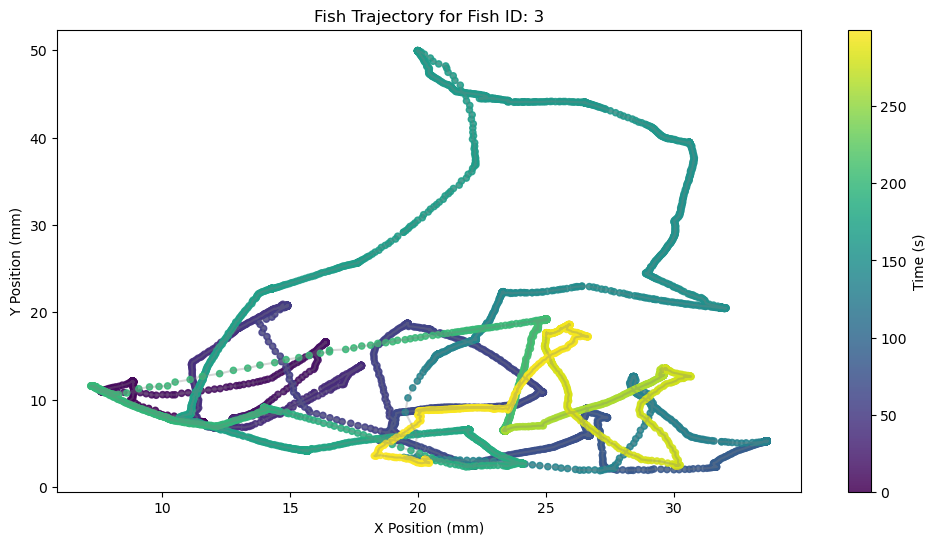

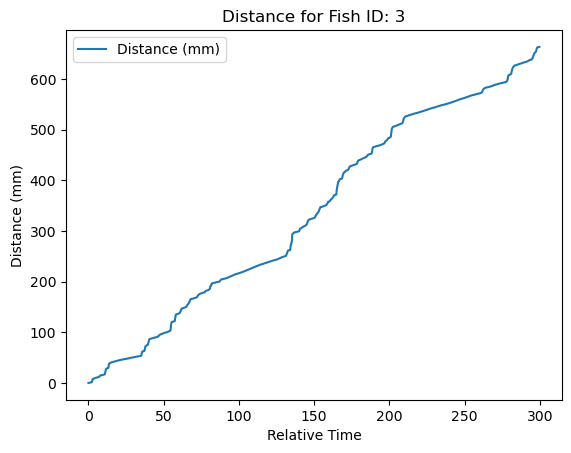

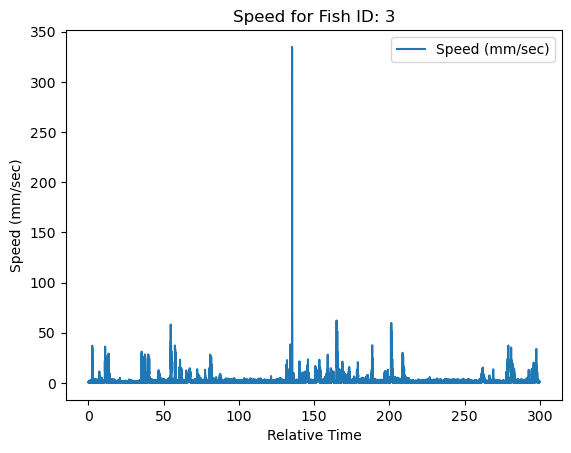

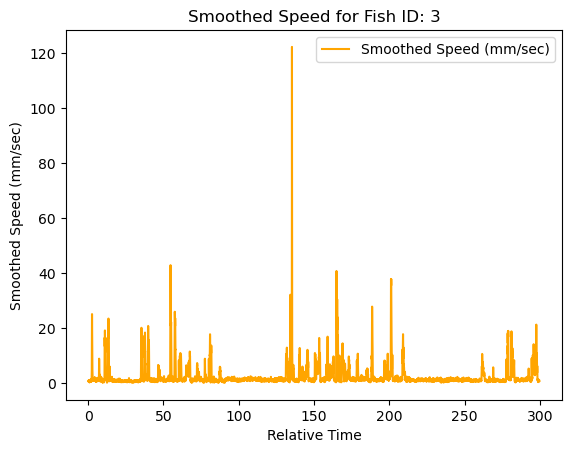

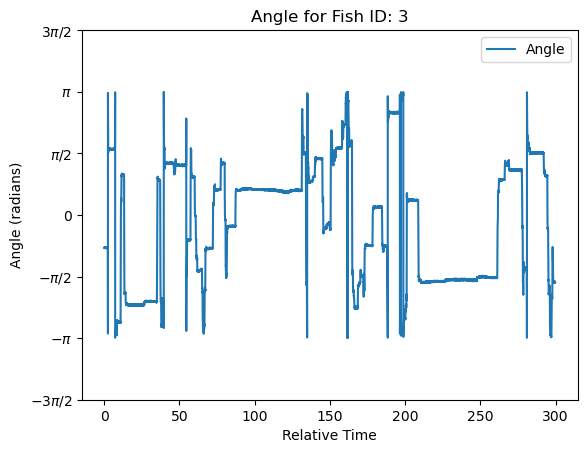

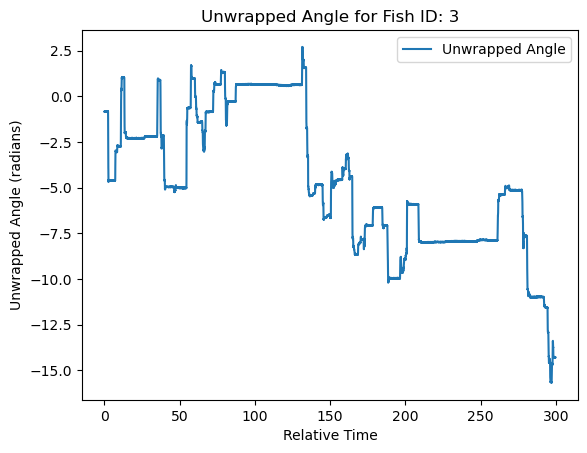

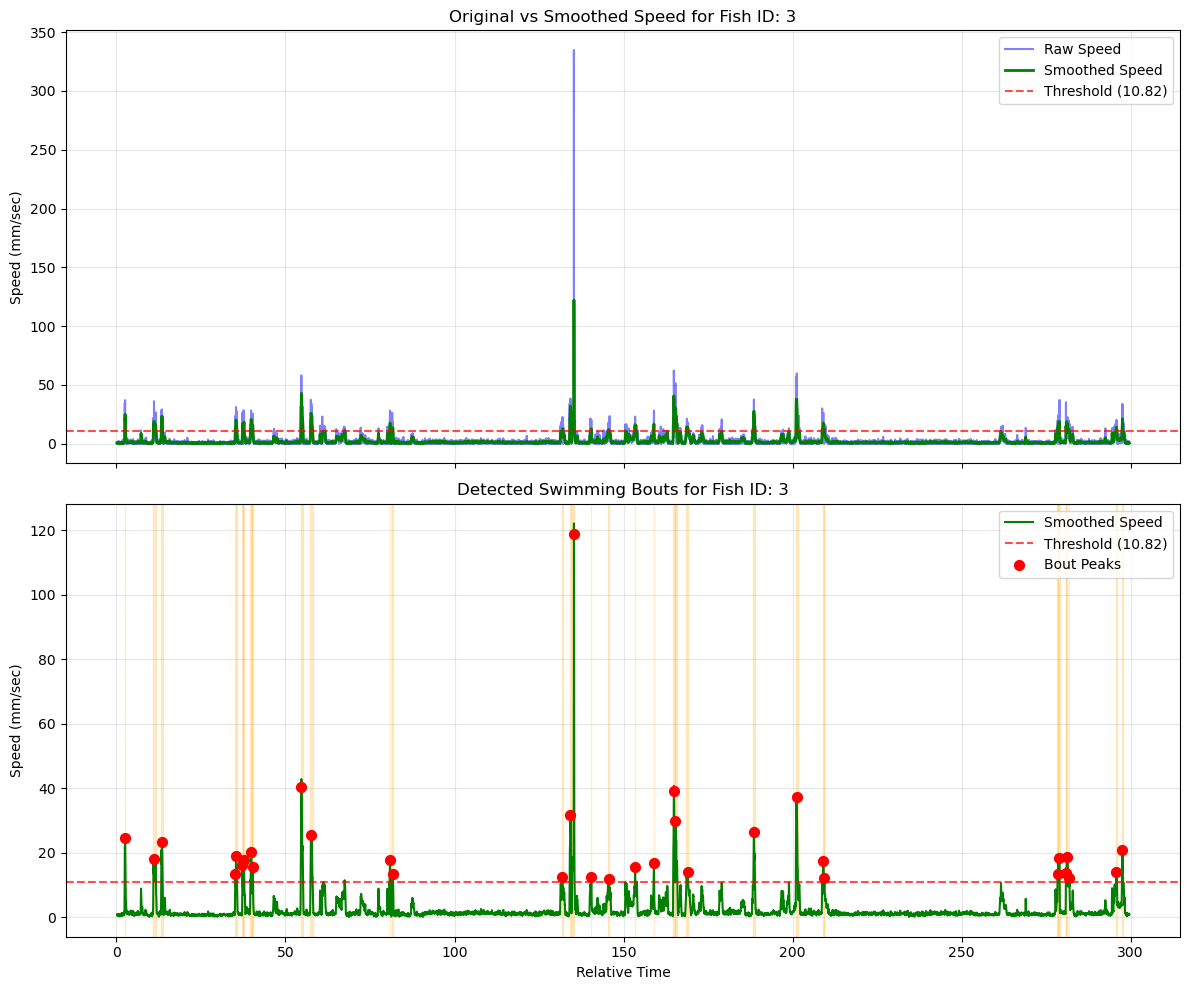

Histograms for Fish ID: 3


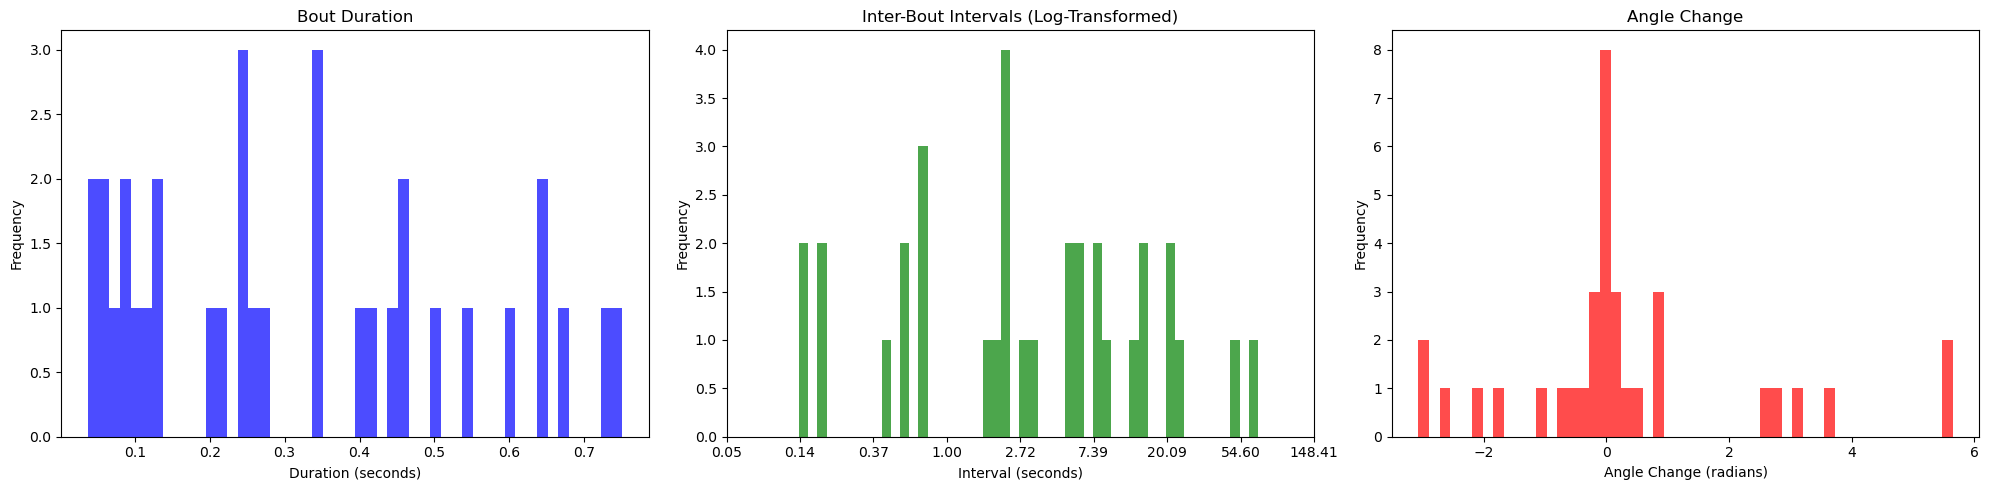

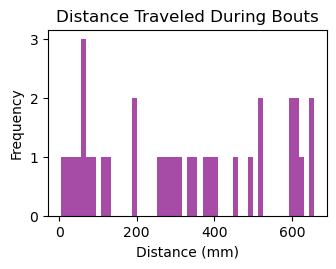

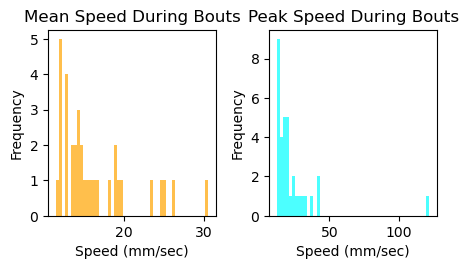

Plotting metrics and printing statistics for Fish ID: 6
Total Number of bouts detected: 35
Average bout duration: 0.47 time units
Average bout peak speed: 23.53 mm/sec
Average bout mean speed: 18.83 mm/sec
Average inter-bout interval: 7.88 time units
Average angle change: 0.04 radians
Average distance traveled: 364.80 mm

Top 5 bouts by peak speed:
     bout_id  start_time  duration  peak_speed
112       31  236.621840  1.621210   52.928742
106       25  164.952624  1.789390   45.504137
102       21  160.589921  1.506648   40.382499
101       20  158.329328  1.731095   35.631495
93        11   83.963463  1.413915   34.882197


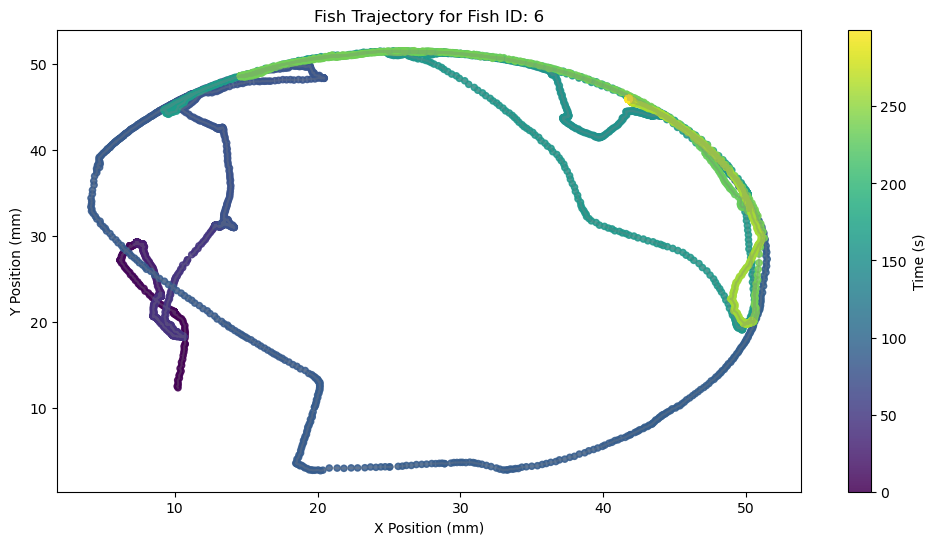

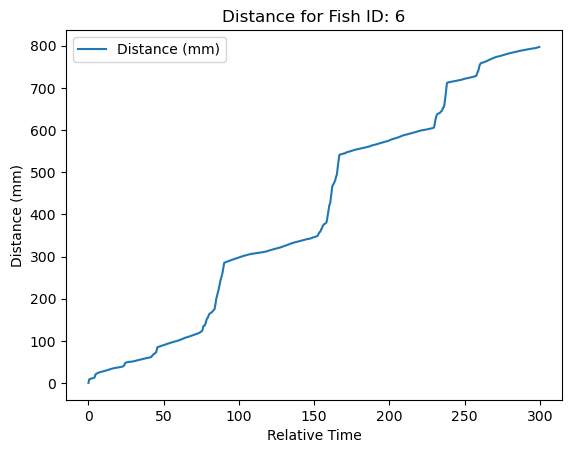

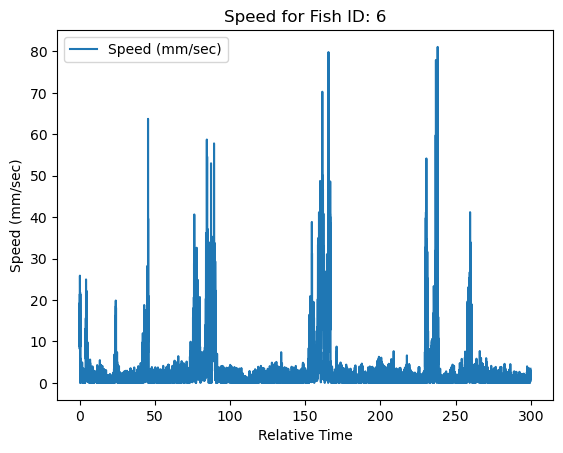

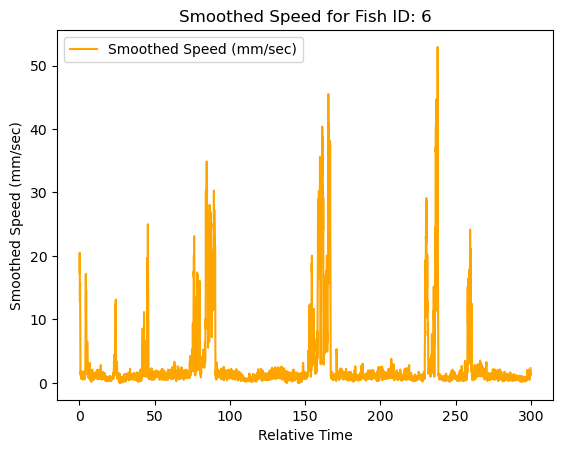

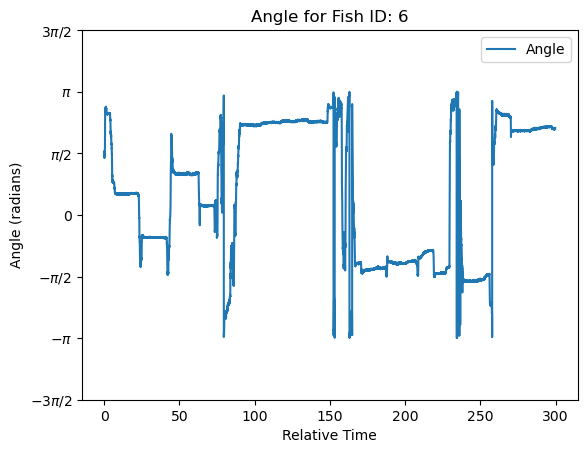

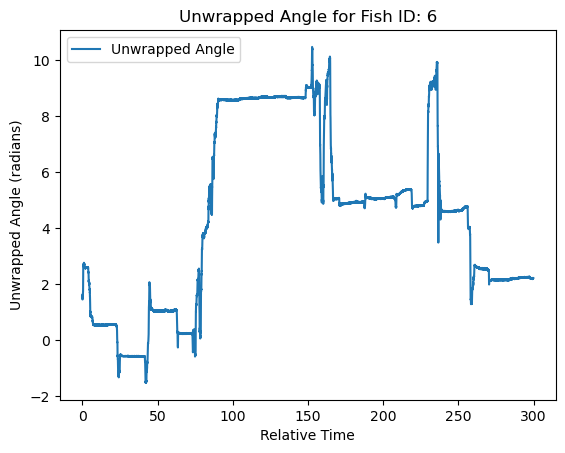

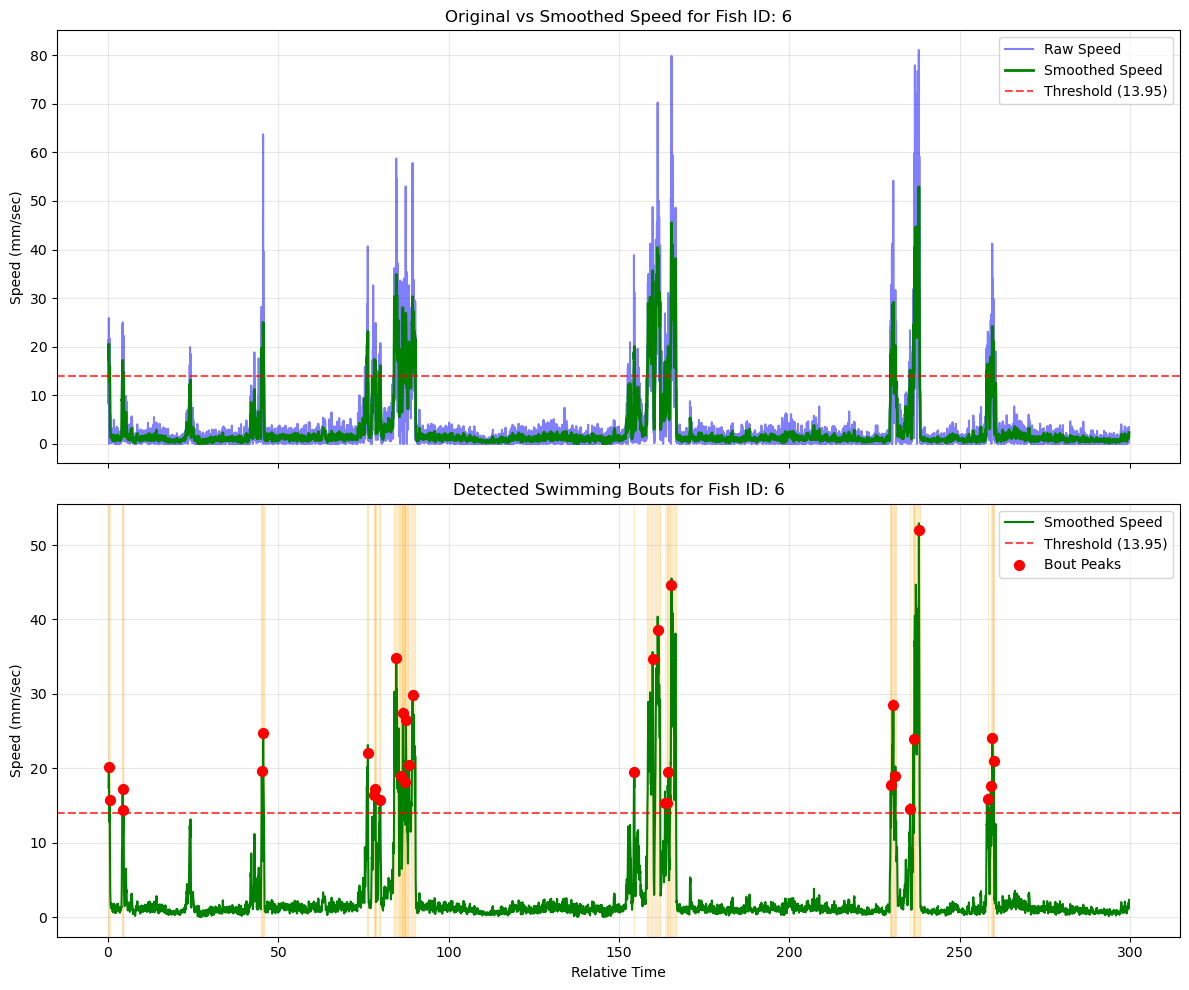

Histograms for Fish ID: 6


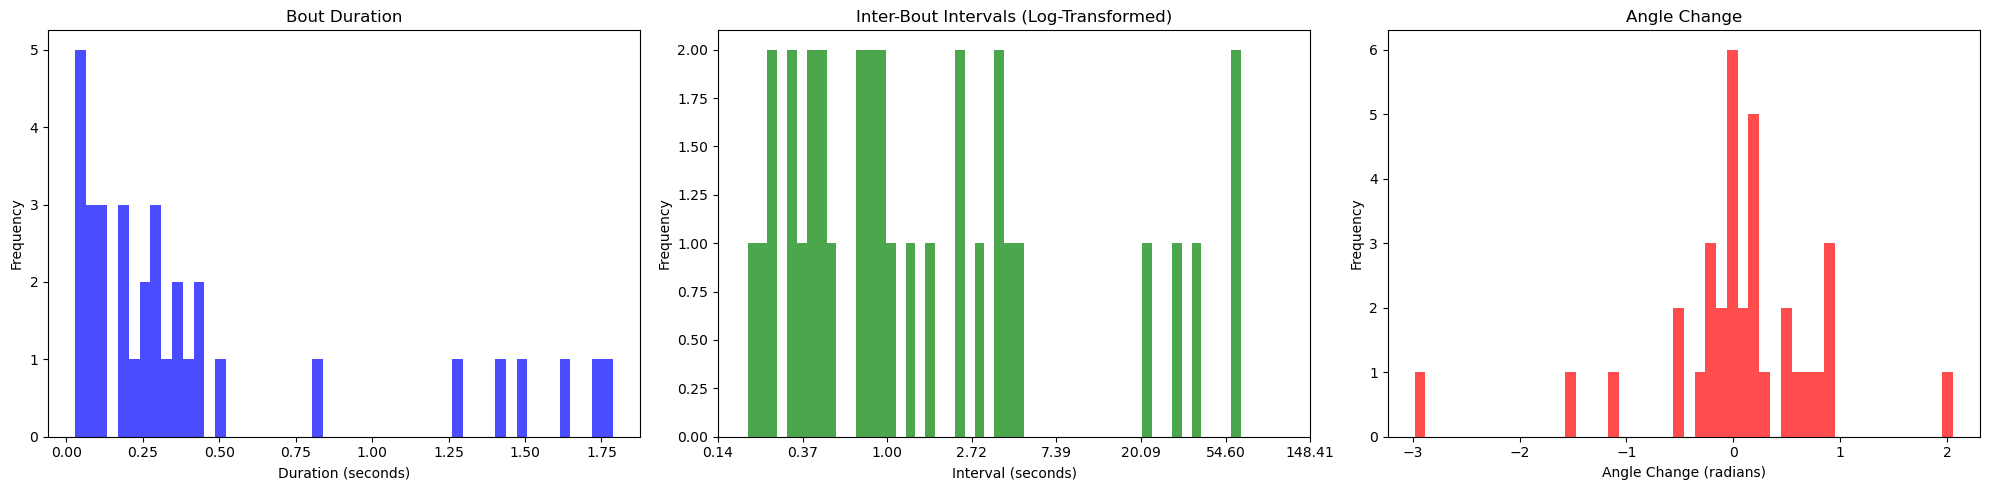

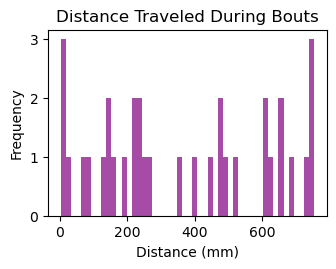

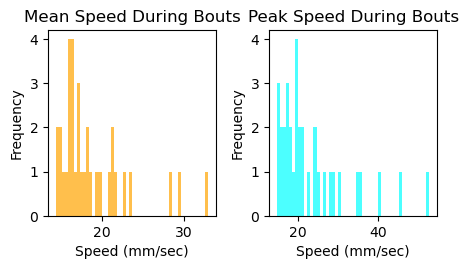

In [168]:
# Example: Plot all metrics and print bout statistics for multiple fish_ids
selected_fish_ids = [3,6]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_bright, bout_properties_df_bright, fish_id, bins=50)

fish_id  relative_time     angle  unfolded_angle
0         2      70.640261  1.582116       -2.889690
1         2      70.658289  1.662270       -2.497707
2         2      70.671029  1.788213       -2.201839
3         2      70.691717  2.072751       -1.991941
4         2      70.729267  2.647034       -1.722256
5         2      72.494956 -0.529799        1.180262
6         2      72.510984 -0.584875        1.378794
7         2      72.526966 -0.548258        1.512848
8         2      72.542039 -0.431382        1.610665
9         2      97.910349 -1.450835        0.272818
10        2      97.927081 -1.354997        0.402431
11        2      97.943494 -1.150421        0.645612
12        2      97.960445 -0.839588        0.852801
13        2     158.927147 -2.933095       -1.342166
14        2     158.943137 -2.898184       -1.120112
15        2     158.959125 -2.864632       -1.003223
16        2     158.975648 -2.644269       -0.844280
Discarded rows: (17, 4)
Kept rows: (17989, 38)

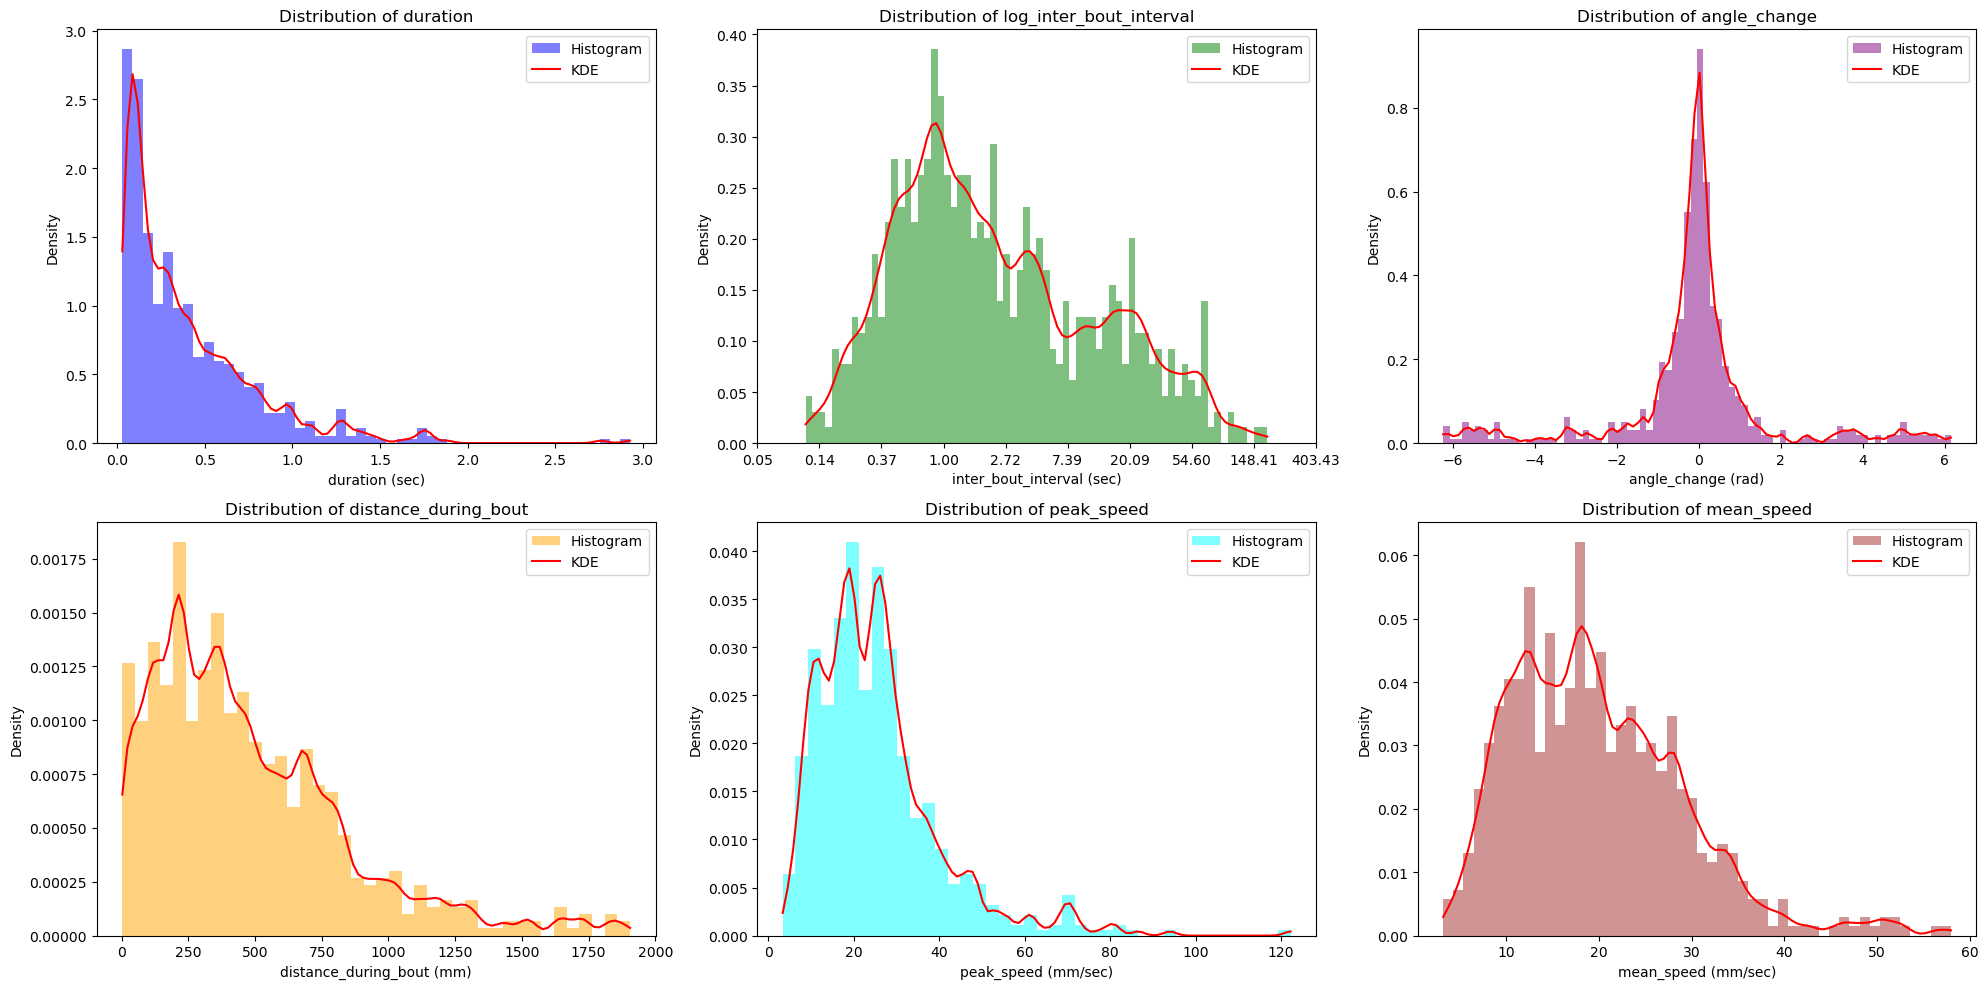

In [170]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }

# Step 1: Calculate KDEs
kde_dict_bright = calculate_kdes(bout_properties_df_bright, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_bright, bout_properties_df_bright, bins_dict)

Estimated bouts_per_path: 29


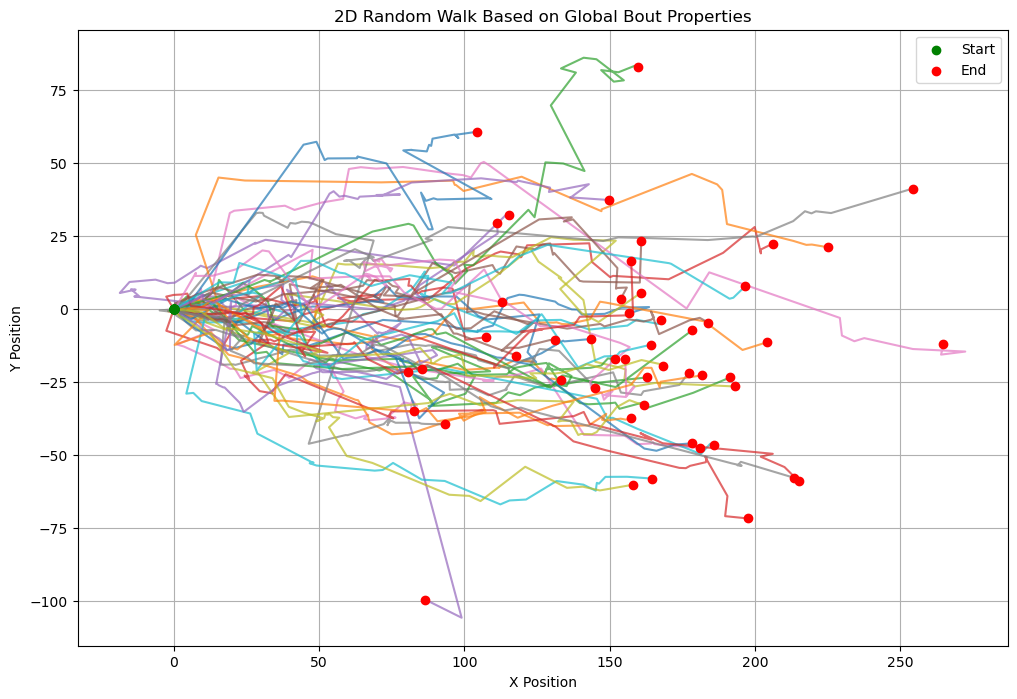

In [172]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_bright,bout_properties_df_bright, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [173]:
dark_df = pd.read_csv(r'.\processed_data\dark_data_20250409.csv')
derived_metrics_df_dark = calculate_derived_metrics(data=dark_df,
    label='dark', output_folder=r'.\processed_data') #change the label to dark

filtered_df_dark = filter_extreme_angle_changes(derived_metrics_df_dark, fish_id=None, window_ms=200)
derived_metrics_df_dark = filtered_df_dark.copy()

bout_properties_df_dark = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_dark,
    label='dark', output_folder=r'.\processed_data', #change the label to dark
    smoothing_method='gaussian', sigma=2)

Derived metrics saved to .\processed_data\derived_metrics_dark_20250508.csv
Bout properties saved to .\processed_data\bout_properties_dark_20250508.csv


Plotting metrics and printing statistics for Fish ID: 2
Total Number of bouts detected: 3
Average bout duration: 0.16 time units
Average bout peak speed: 13.13 mm/sec
Average bout mean speed: 6.21 mm/sec
Average inter-bout interval: 94.05 time units
Average angle change: -0.57 radians
Average distance traveled: 121.29 mm

Top 5 bouts by peak speed:
   bout_id  start_time  duration  peak_speed
0        1    0.028577  0.404272   33.632253
1        2  151.326491  0.040561    2.992984
2        3  188.129628  0.036880    2.774885


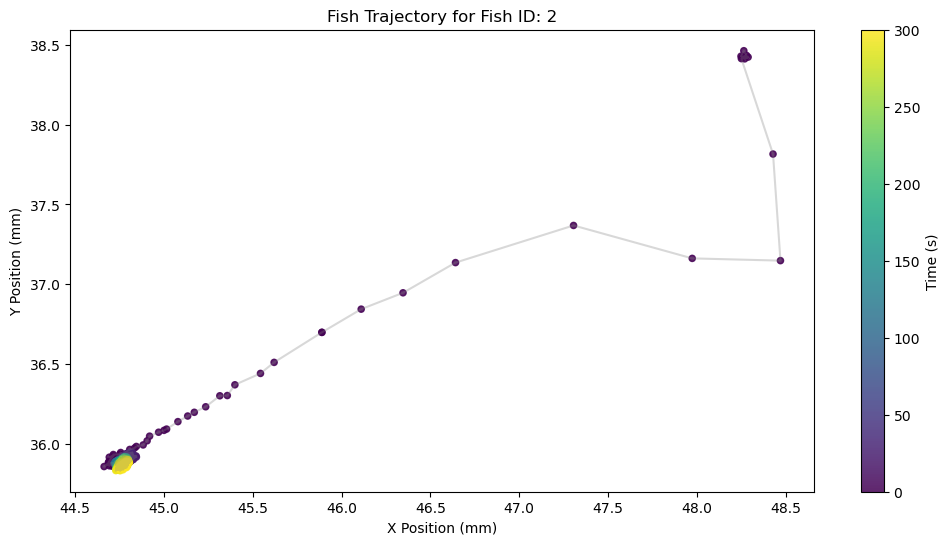

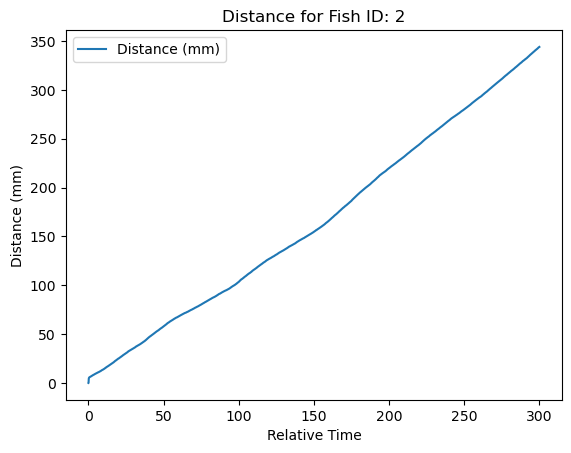

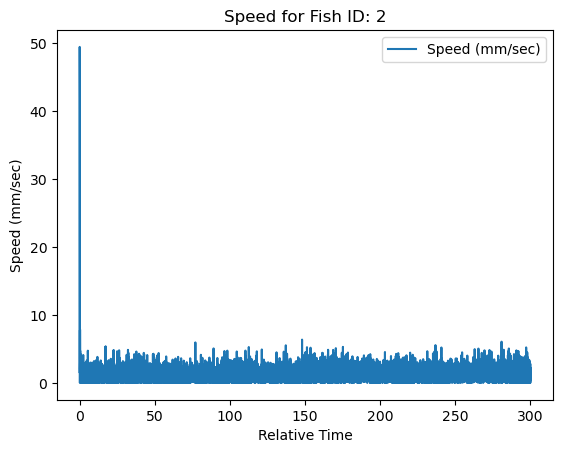

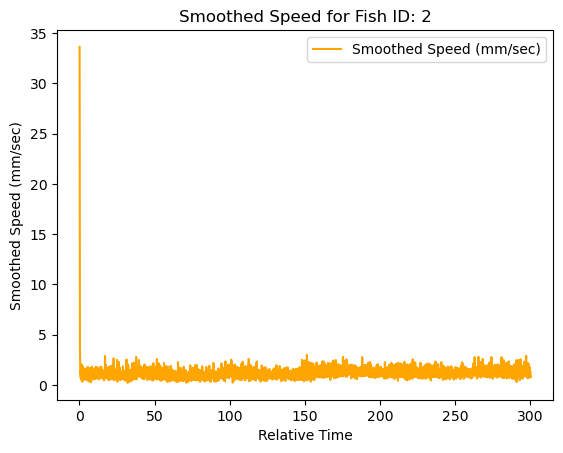

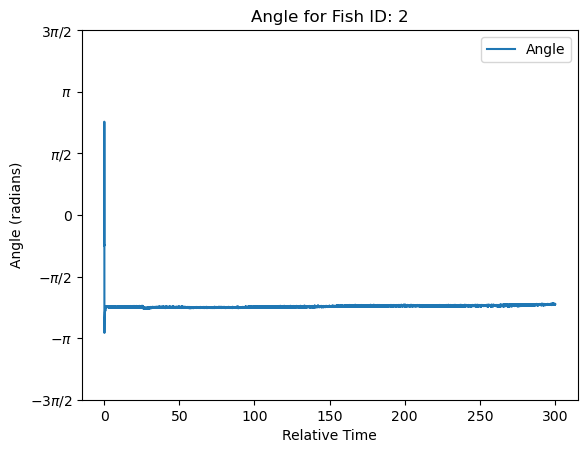

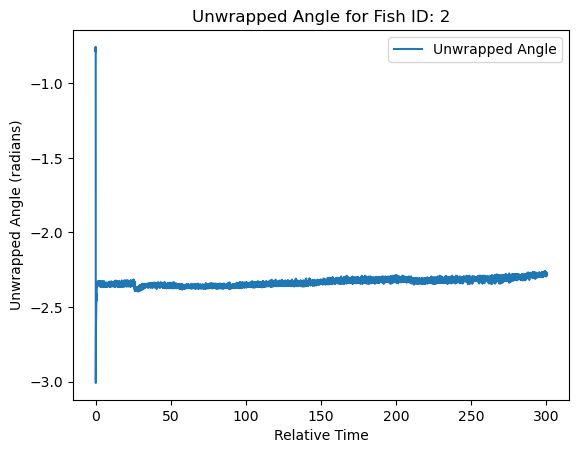

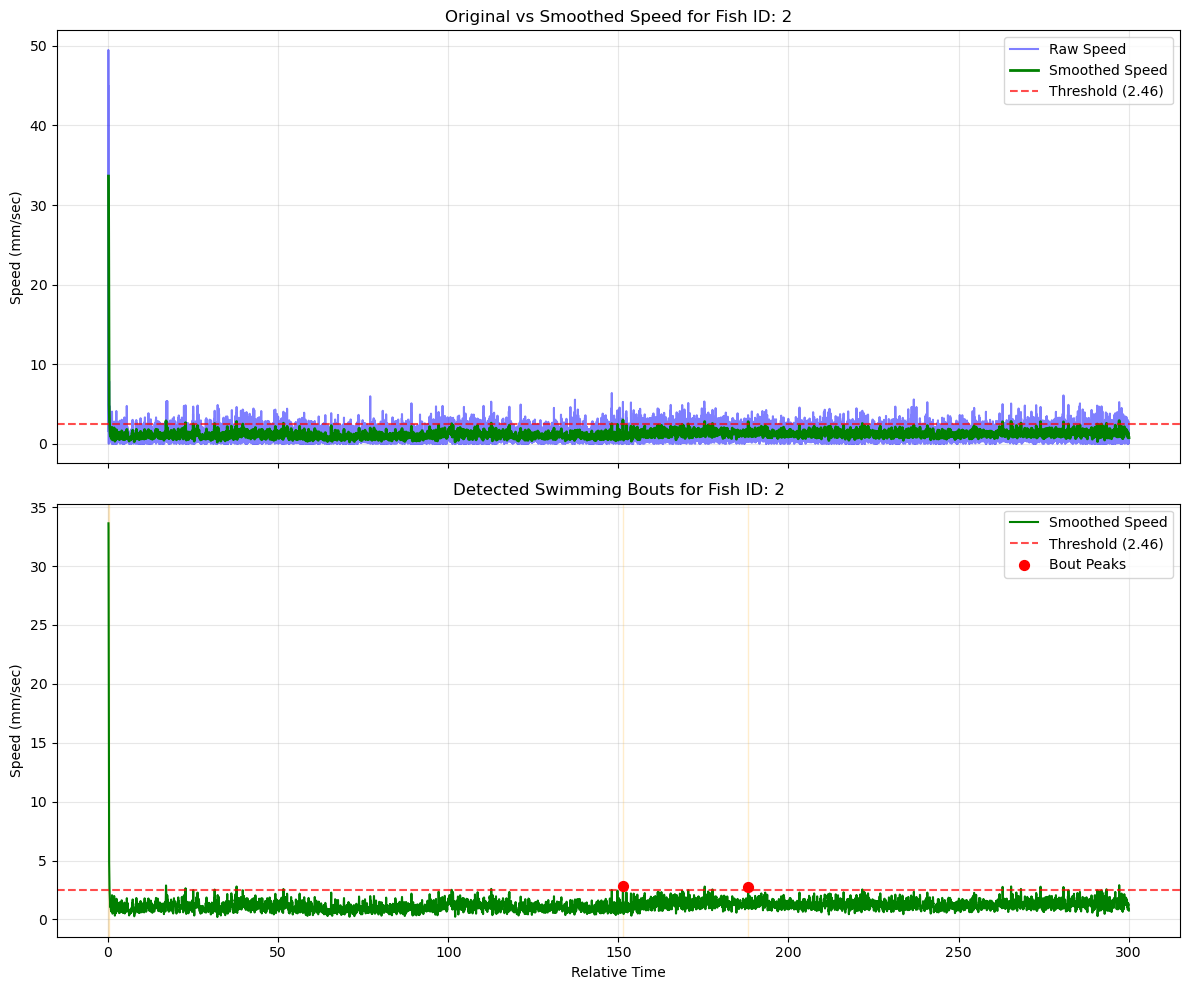

Histograms for Fish ID: 2


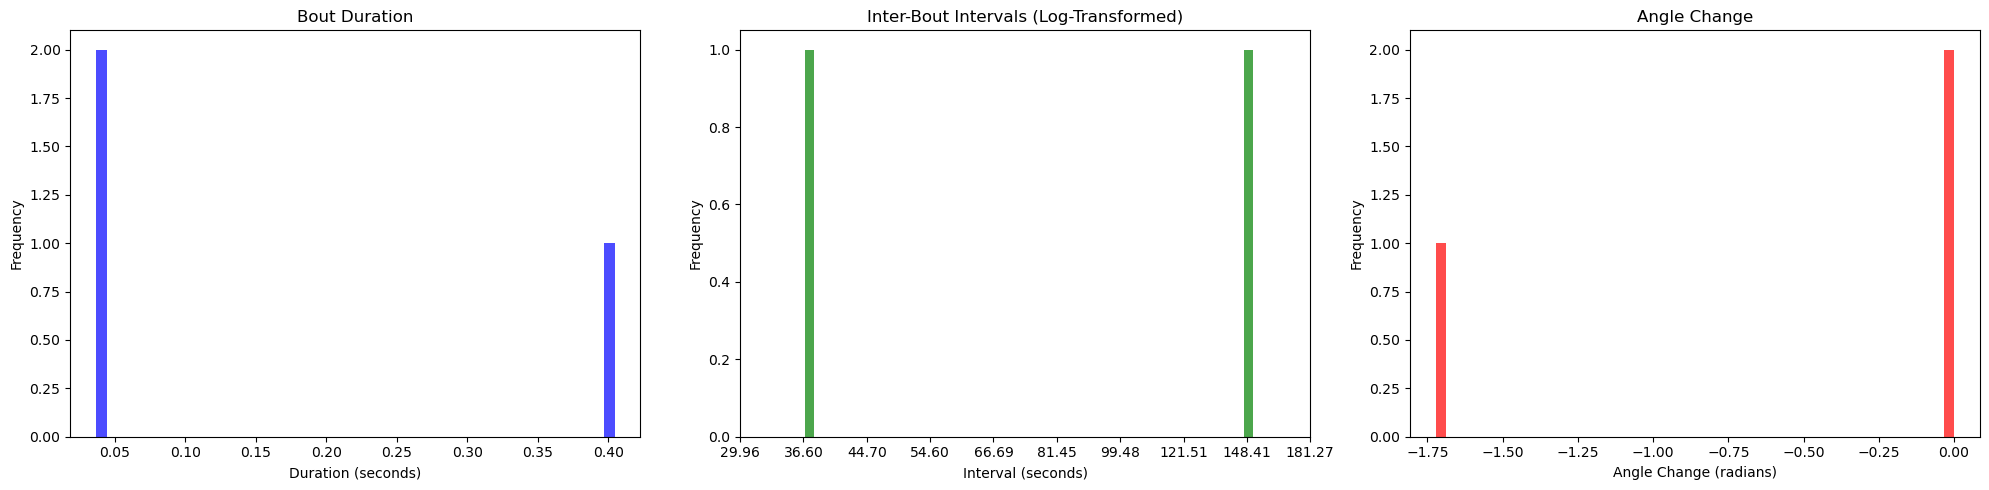

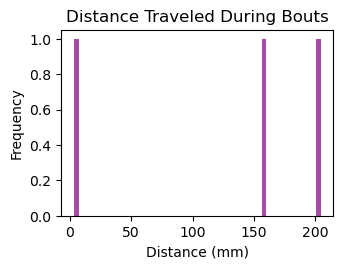

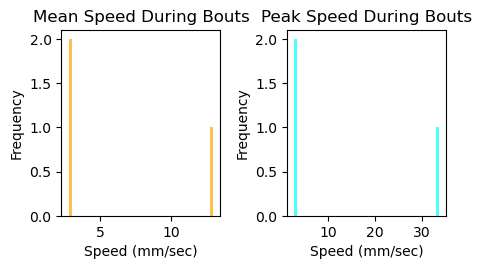

In [174]:
# Example: Plot all metrics and print bout statistics for multiple fish_ids
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_dark, bout_properties_df_dark, fish_id, bins=50)

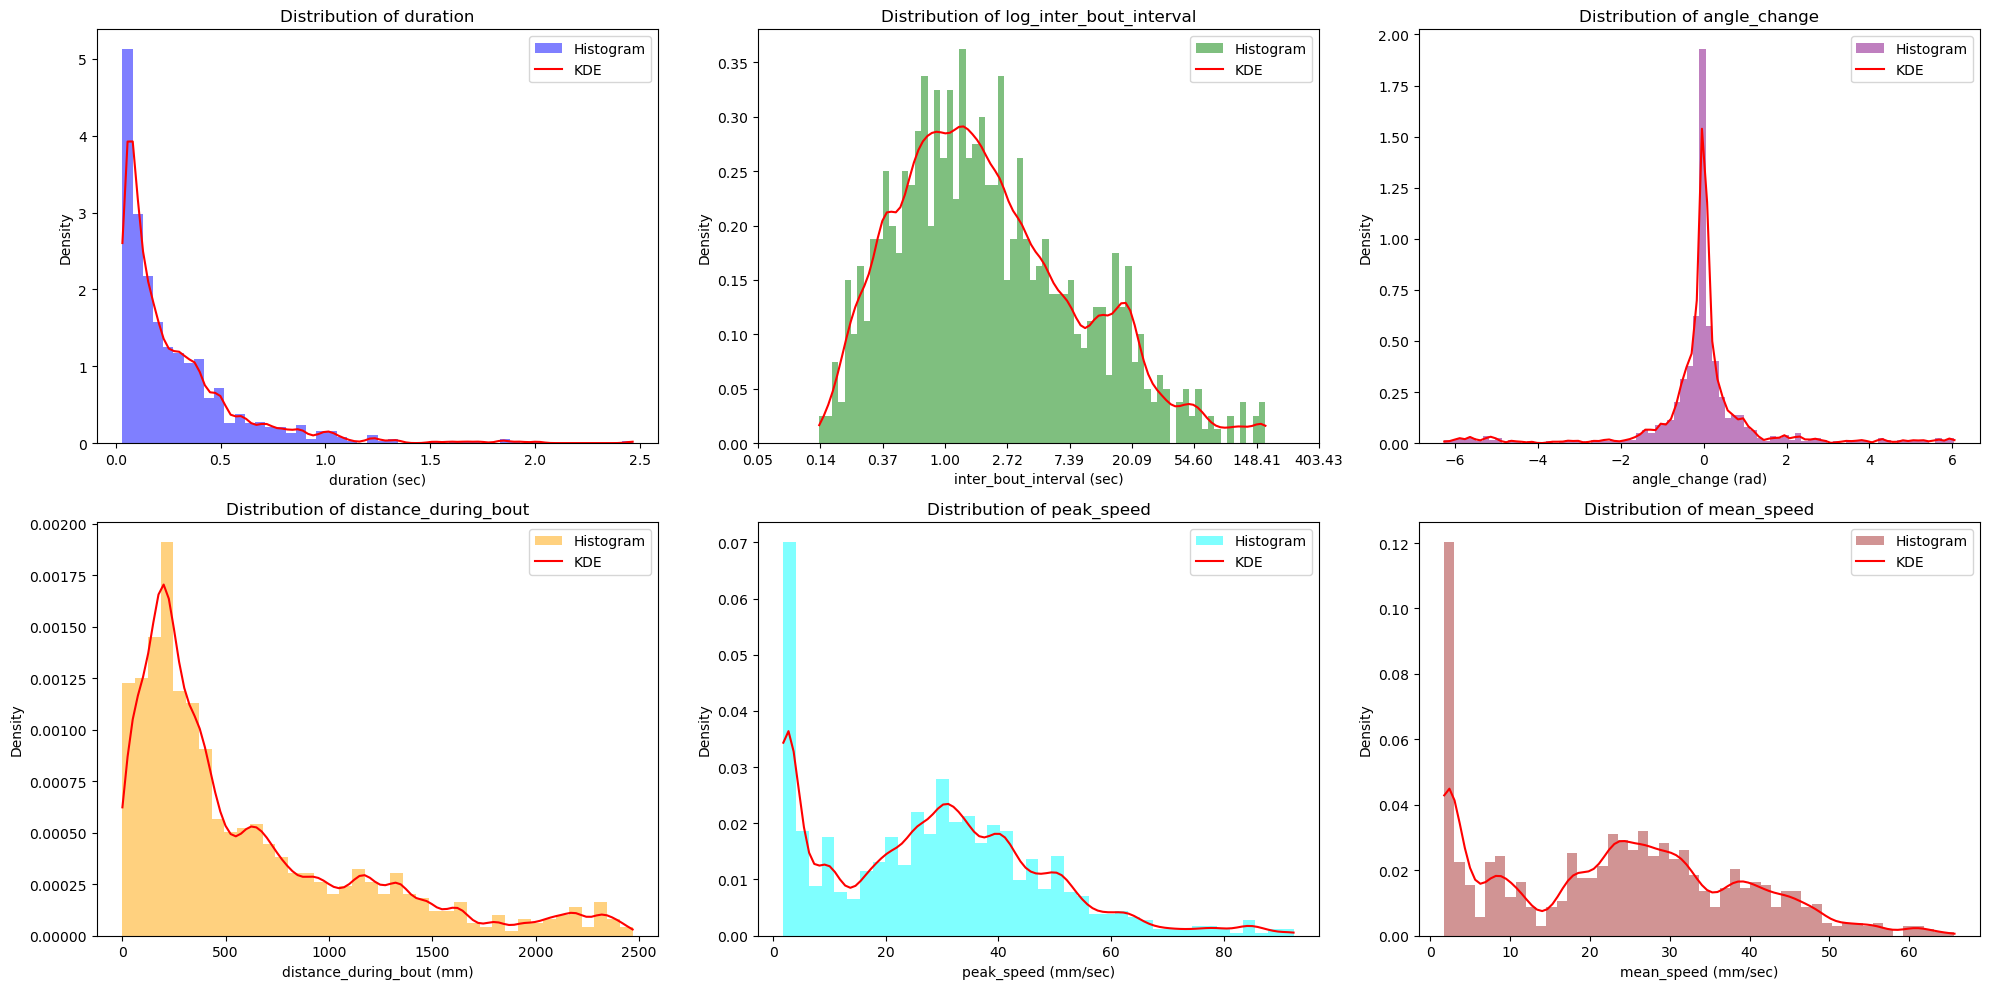

In [175]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }

# Step 1: Calculate KDEs
kde_dict_dark = calculate_kdes(bout_properties_df_dark, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_dark, bout_properties_df_dark, bins_dict)

Estimated bouts_per_path: 37


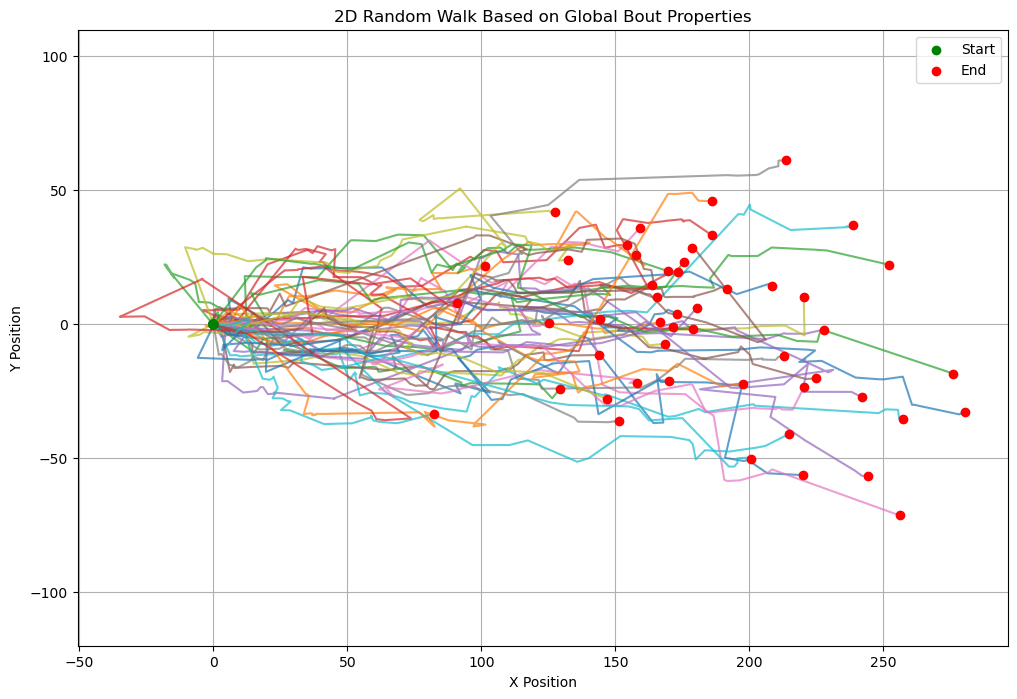

In [86]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_dark,bout_properties_df_dark, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [176]:
phototaxis_df = pd.read_csv(r'.\processed_data\phototaxis_data_20250409.csv')
#the column 'phototaxis_polarity' indicates whether 
# the dark region is to the left (-1) or to the right (+1) of the fish
phototaxis_df_left = phototaxis_df[phototaxis_df['phototaxis_polarity'] == 1]
phototaxis_df_right = phototaxis_df[phototaxis_df['phototaxis_polarity'] == -1]

derived_metrics_df_phototaxis = calculate_derived_metrics(data=phototaxis_df,
    label='phototaxis', output_folder=r'.\processed_data')
filtered_df_phototaxis = filter_extreme_angle_changes(derived_metrics_df_phototaxis, fish_id=None, window_ms=200)
derived_metrics_df_phototaxis = filtered_df_phototaxis.copy()


#Dark left
derived_metrics_df_phototaxis_left = calculate_derived_metrics(data=phototaxis_df_left,
    label='phototaxis_left', output_folder=r'.\processed_data')

filtered_df_phototaxis_left = filter_extreme_angle_changes(derived_metrics_df_phototaxis_left, fish_id=None, window_ms=200)
derived_metrics_df_phototaxis_left = filtered_df_phototaxis_left.copy()

bout_properties_df_phototaxis_left = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_phototaxis_left,
    label='phototaxis_left', output_folder=r'.\processed_data',
    smoothing_method='gaussian', sigma=2)

#Dark right
derived_metrics_df_phototaxis_right = calculate_derived_metrics(data=phototaxis_df_right,
    label='phototaxis_right', output_folder=r'.\processed_data')

filtered_df_phototaxis_right = filter_extreme_angle_changes(derived_metrics_df_phototaxis_right, fish_id=None, window_ms=200)
derived_metrics_df_phototaxis_right = filtered_df_phototaxis_right.copy()

bout_properties_df_phototaxis_right = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_phototaxis_right,
    label='phototaxis_right', output_folder=r'.\processed_data',
    smoothing_method='gaussian', sigma=2)

Derived metrics saved to .\processed_data\derived_metrics_phototaxis_20250508.csv
Derived metrics saved to .\processed_data\derived_metrics_phototaxis_left_20250508.csv


KeyboardInterrupt: 

In [ ]:
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_phototaxis_left, bout_properties_df_phototaxis_left, fish_id, bins=50)

In [ ]:
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_phototaxis_right, bout_properties_df_phototaxis_right, fish_id, bins=50)

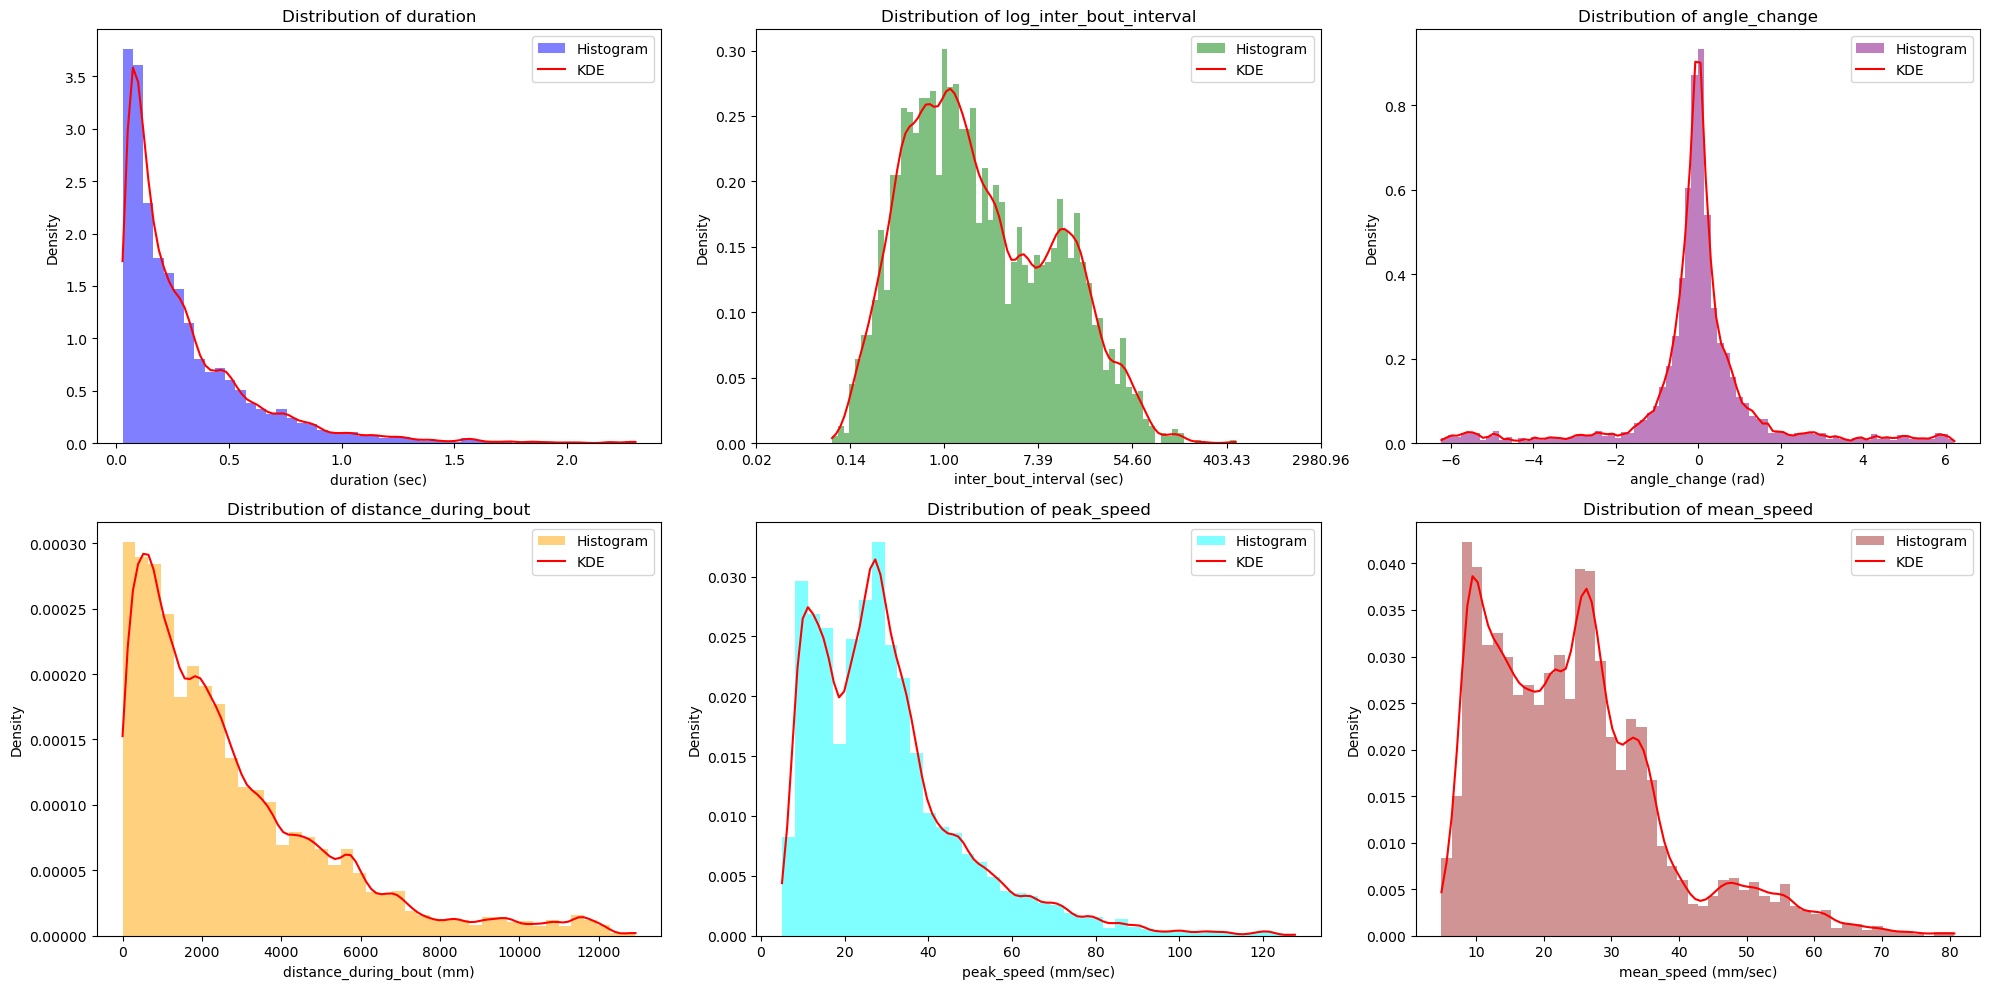

In [91]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }
# Step 1: Calculate KDEs
kde_dict_phototaxis_left = calculate_kdes(bout_properties_df_phototaxis_left, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_phototaxis_left, bout_properties_df_phototaxis_left, bins_dict)

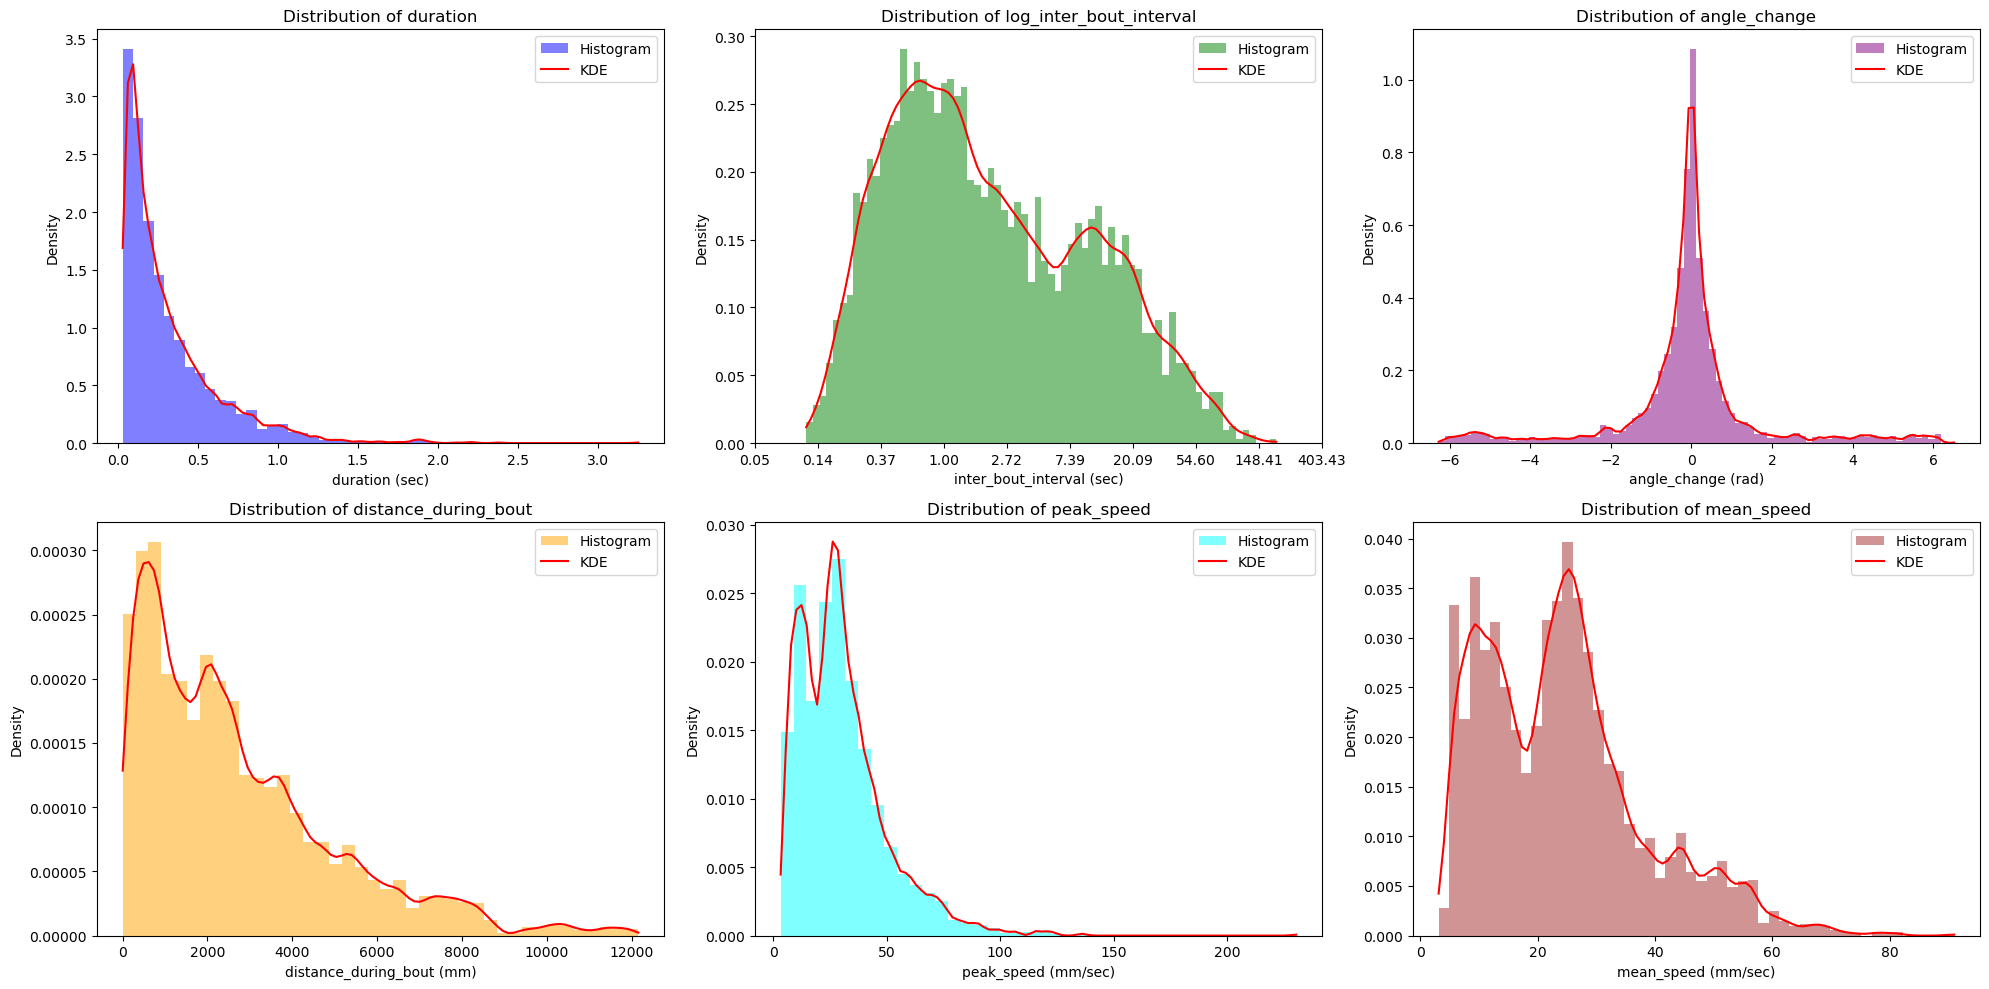

In [92]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }

# Step 1: Calculate KDEs
kde_dict_phototaxis_right = calculate_kdes(bout_properties_df_phototaxis_right, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_phototaxis_right, bout_properties_df_phototaxis_right, bins_dict)

Estimated bouts_per_path: 147


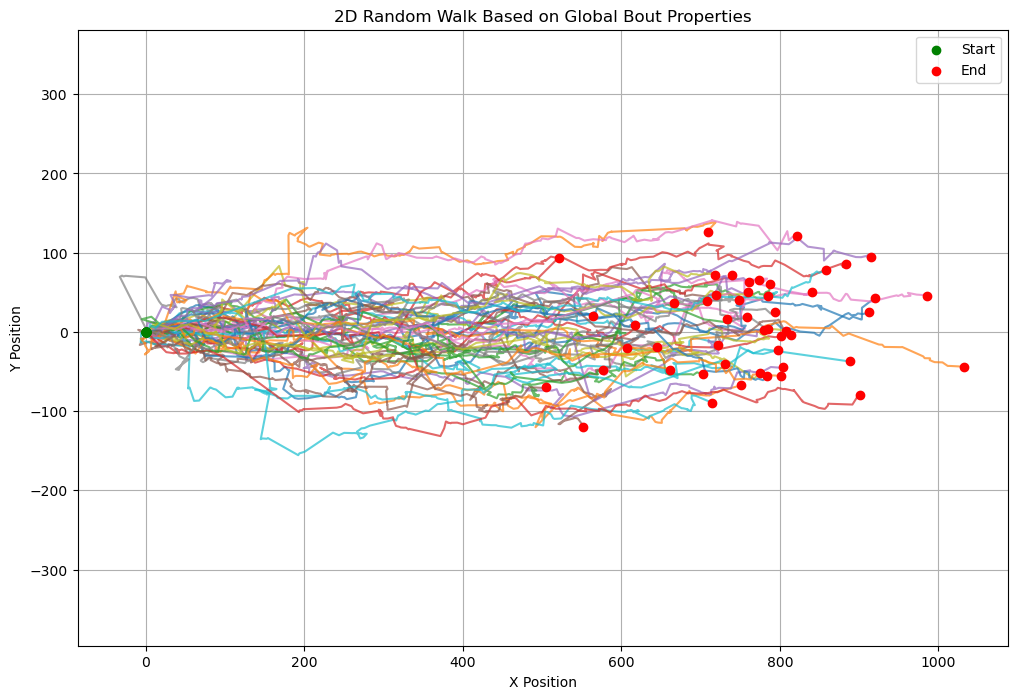

In [89]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_phototaxis_left,bout_properties_df_phototaxis_left, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

Estimated bouts_per_path: 144


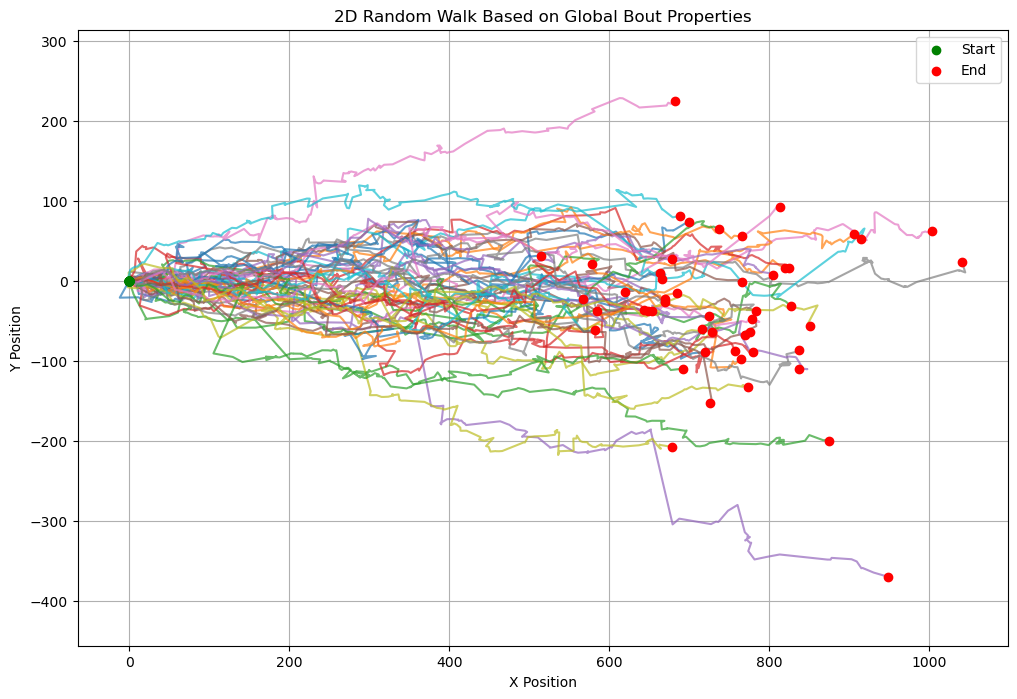

In [90]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_phototaxis_right,bout_properties_df_phototaxis_right, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [68]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

def plot_bout_property_comparison(bout_properties_df1, bout_properties_df2, label1, label2, column, bins=100):
    """
    Plot QQ plot and overlay histograms for a specified bout property between two datasets.

    Parameters:
    - bout_properties_df1 (pd.DataFrame): First bout properties DataFrame.
    - bout_properties_df2 (pd.DataFrame): Second bout properties DataFrame.
    - label1 (str): Label for the first dataset (e.g., 'Bright').
    - label2 (str): Label for the second dataset (e.g., 'Phototaxis Left').
    - column (str): Column to compare (e.g., 'duration', 'angle_change').
    - bins (int): Number of bins for the histograms (default: 100).
    """
    # Extract data for the specified column
    data1 = bout_properties_df1[column].dropna()
    data2 = bout_properties_df2[column].dropna()

    # Create histograms for the data
    hist_data1 = np.histogram(data1, bins=bins, density=False)[0]
    hist_data2 = np.histogram(data2, bins=bins, density=False)[0]

    # Create ProbPlot objects for QQ plot
    pp_x = sm.ProbPlot(data1)
    pp_y = sm.ProbPlot(data2)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    #  Plot the QQ plot on the first subplot
    qqplot_2samples(pp_x, pp_y, xlabel=None, ylabel=None, line='45', ax=axes[0])
    axes[0].set_title(f'QQ Plot of {column.capitalize()}: {label1} vs {label2}')
    axes[0].grid()

    # Automatically set x-axis limits based on observed quantiles
    observed_min = min(data1.min(), data2.min())
    observed_max = max(data1.max(), data2.max())
    axes[0].set_xlim(observed_min, observed_max)

    # Overlay the histograms on the second subplot
    bins_range = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), bins)
    axes[1].hist(data1, bins=bins_range, alpha=0.7, label=label1, color='blue', density=True)
    axes[1].hist(data2, bins=bins_range, alpha=0.5, label=label2, color='green', density=True)
    axes[1].set_title(f'Histogram of {column.capitalize()}: {label1} vs {label2}')
    axes[1].set_xlabel(f'{column.capitalize()}')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

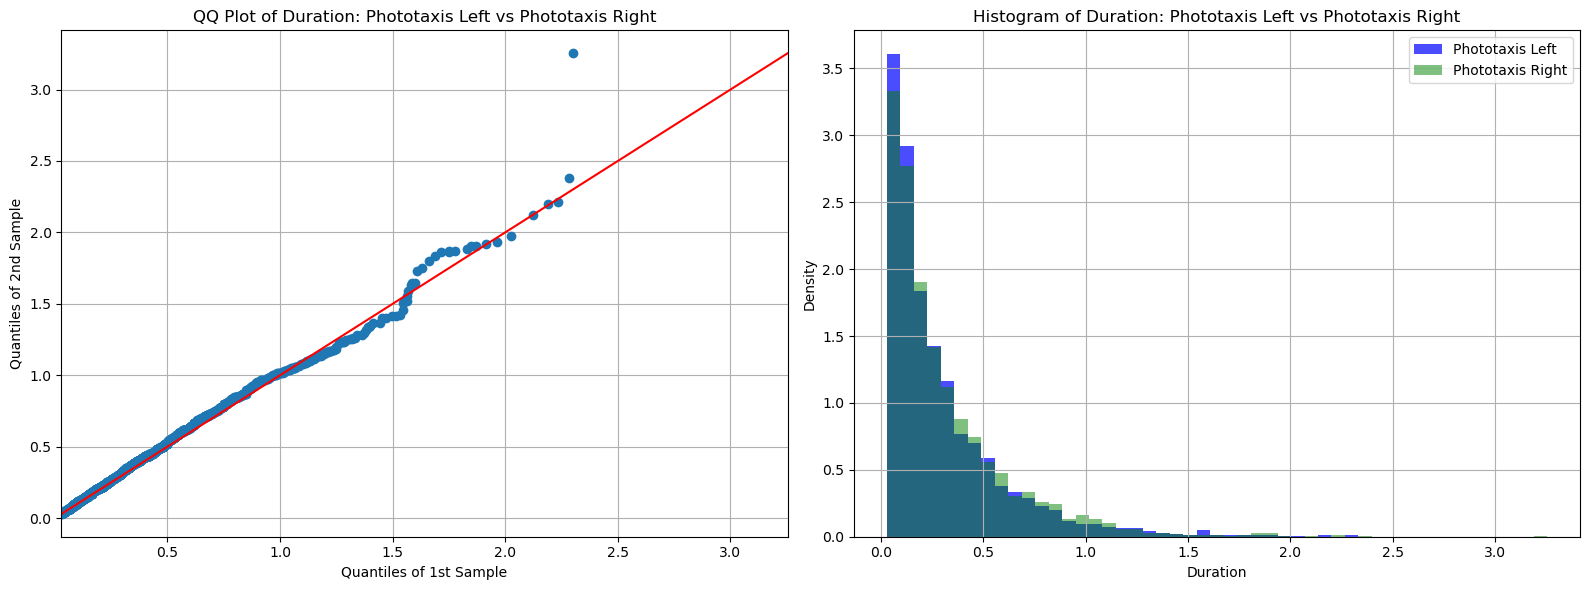

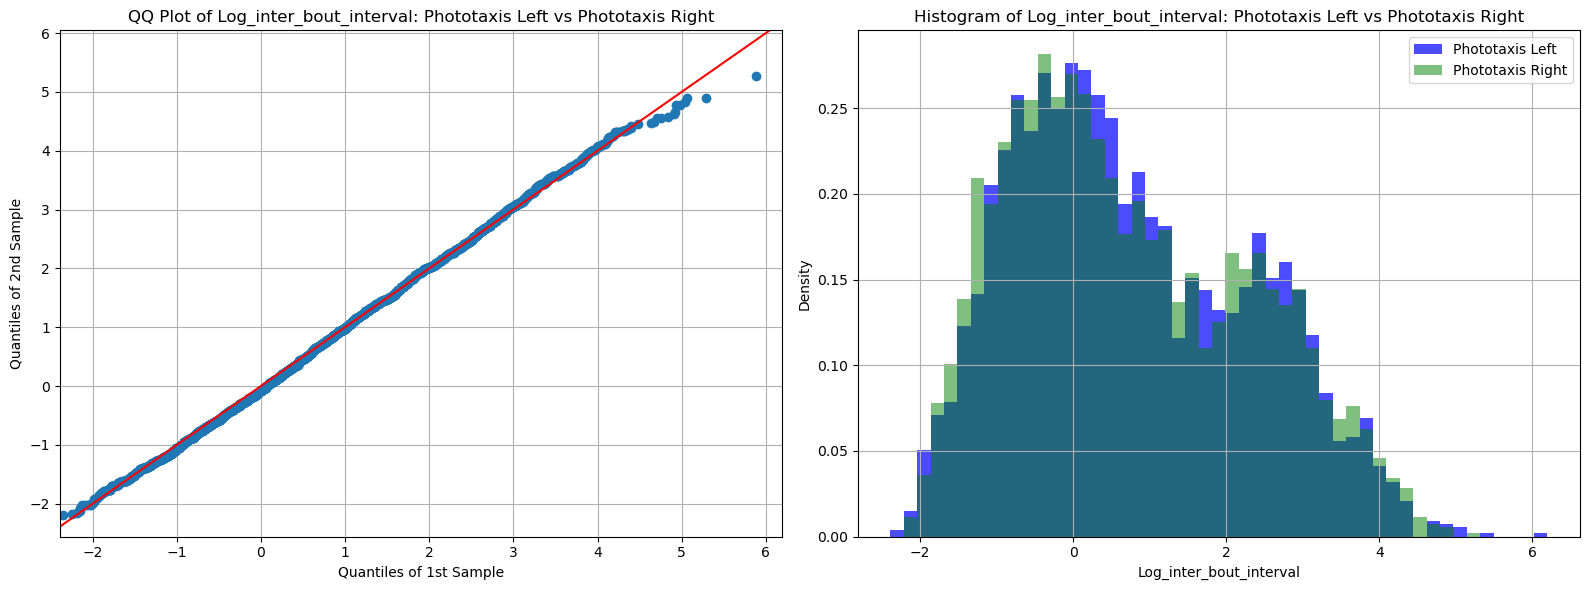

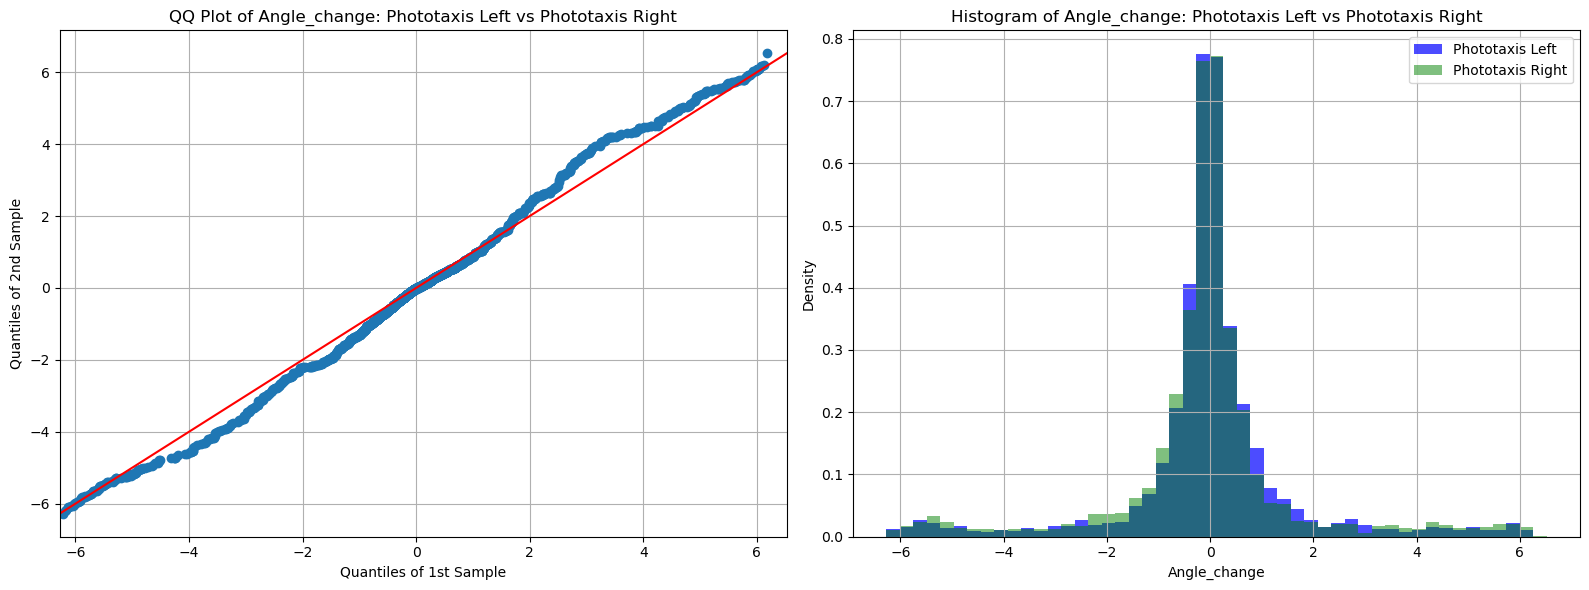

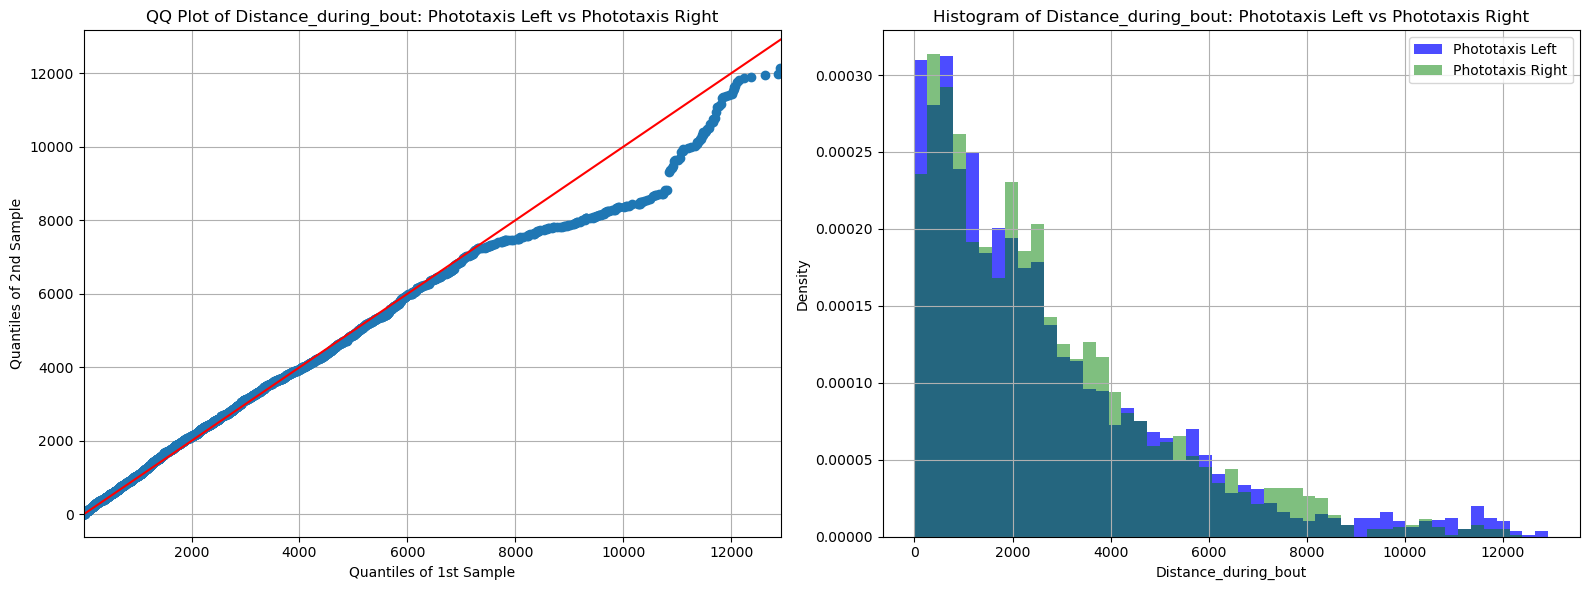

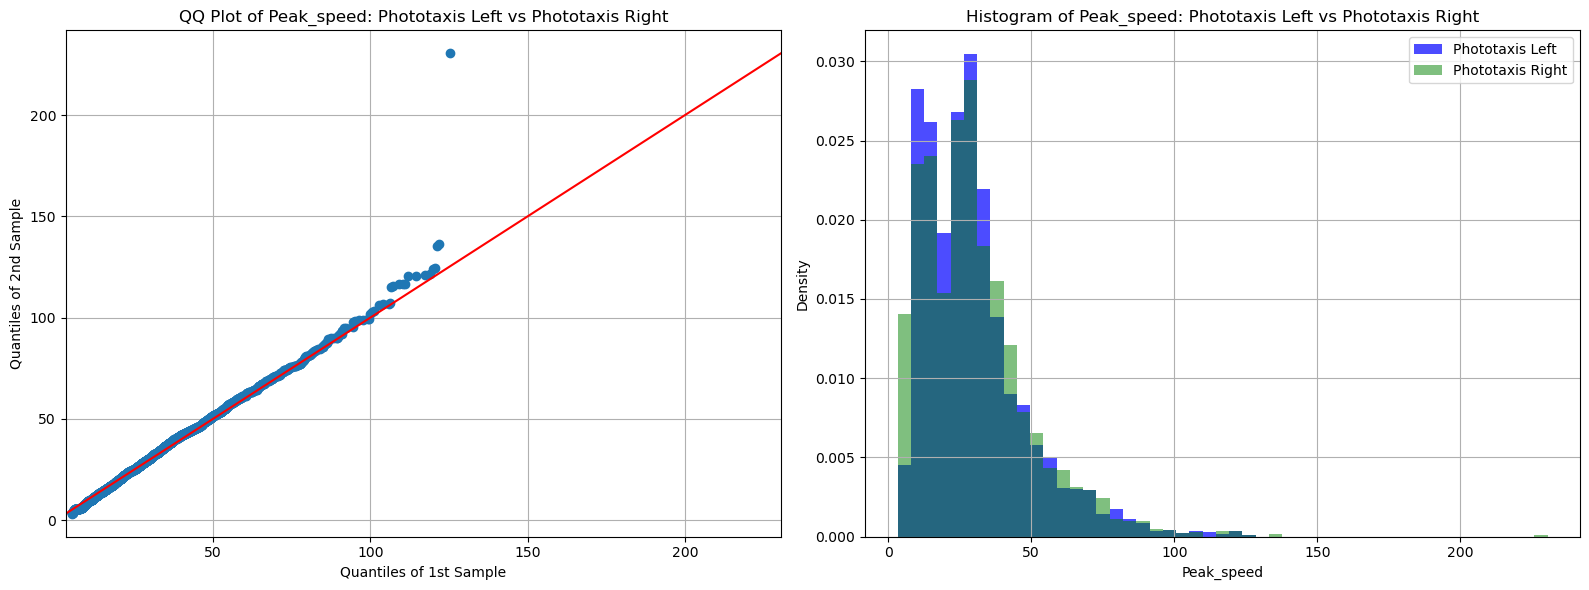

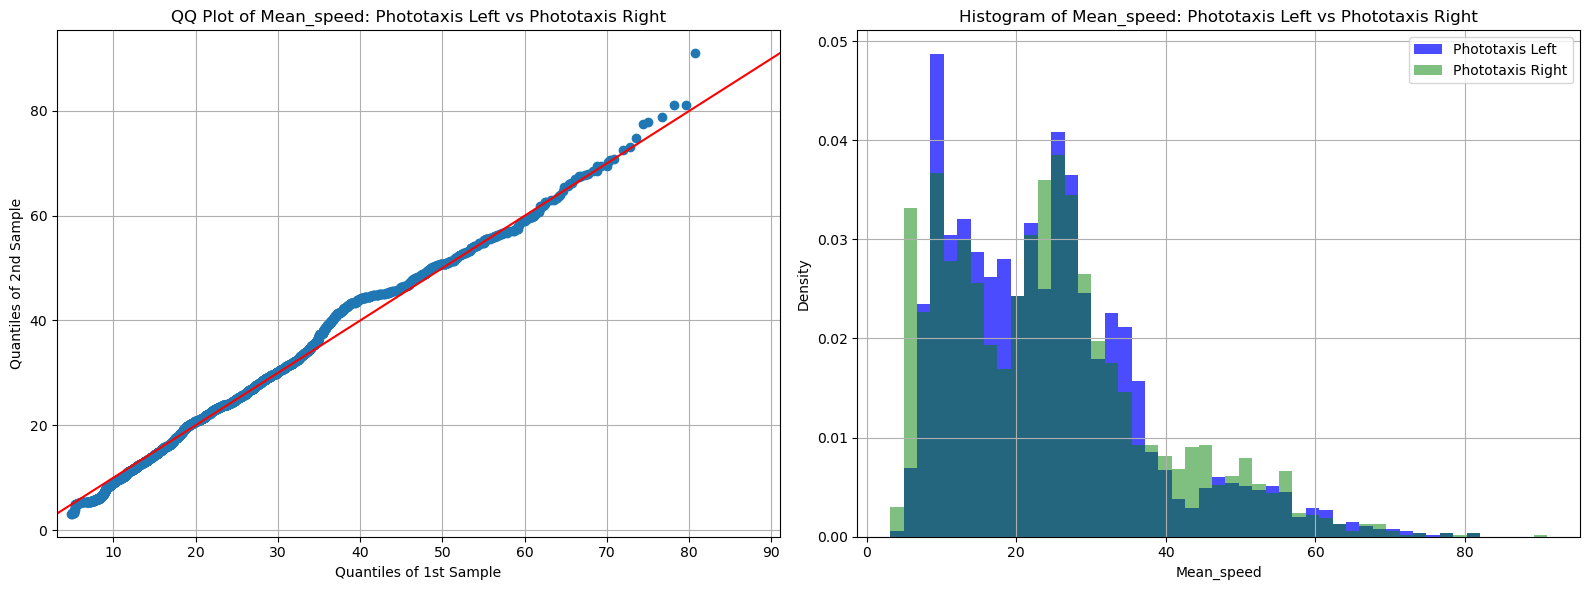

In [70]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_phototaxis_left,
        bout_properties_df2=bout_properties_df_phototaxis_right,
        label1='Phototaxis Left',
        label2='Phototaxis Right',
        column=column,
        bins=50
    )

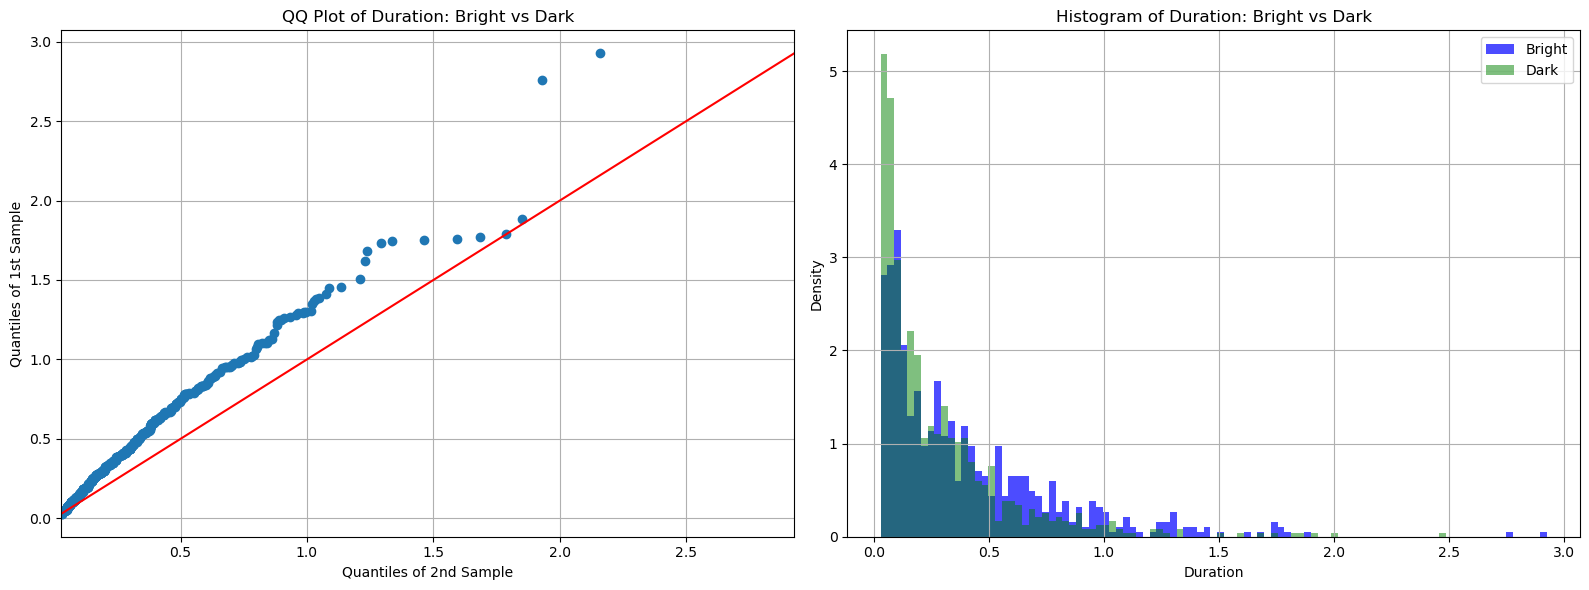

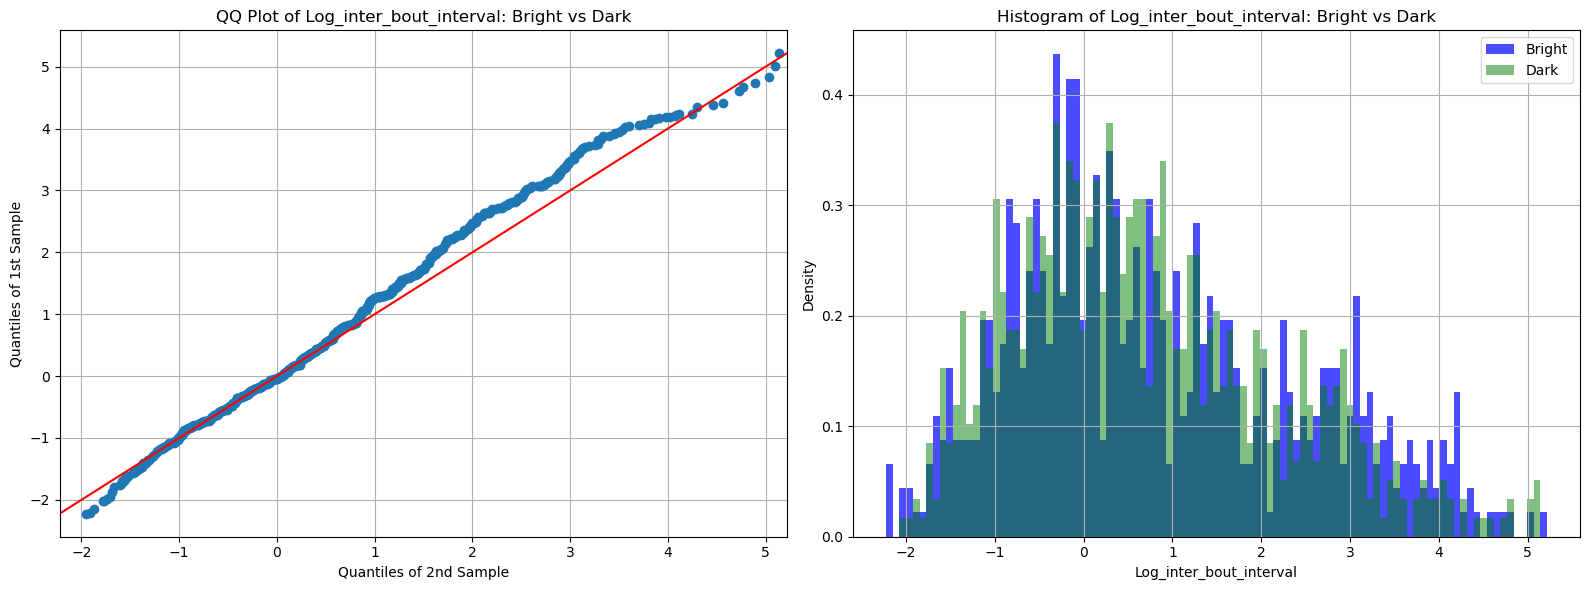

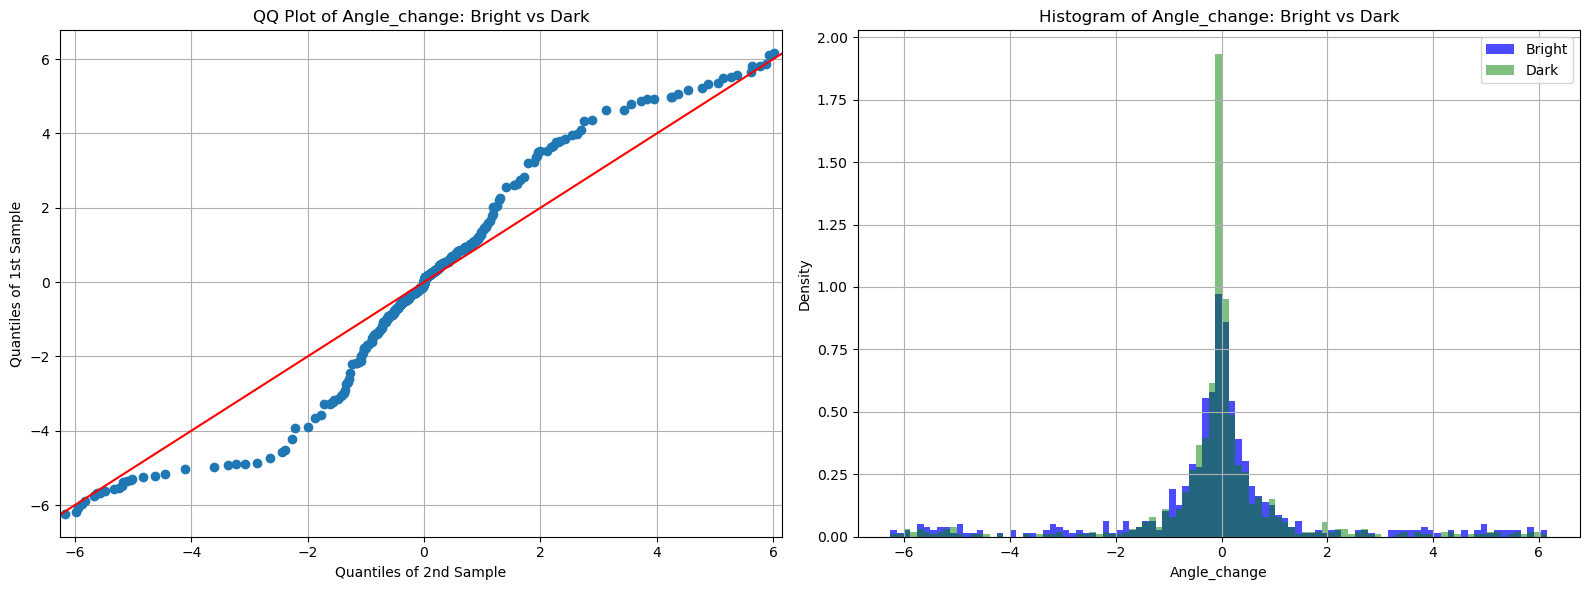

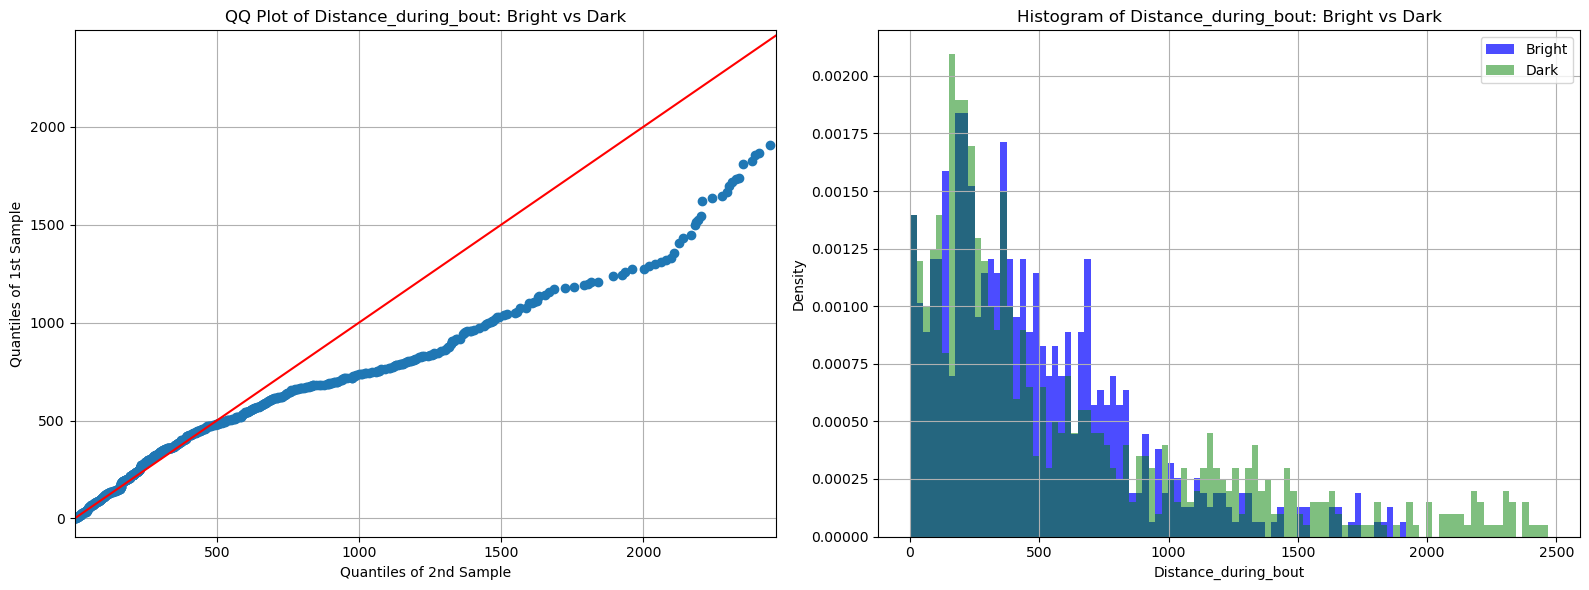

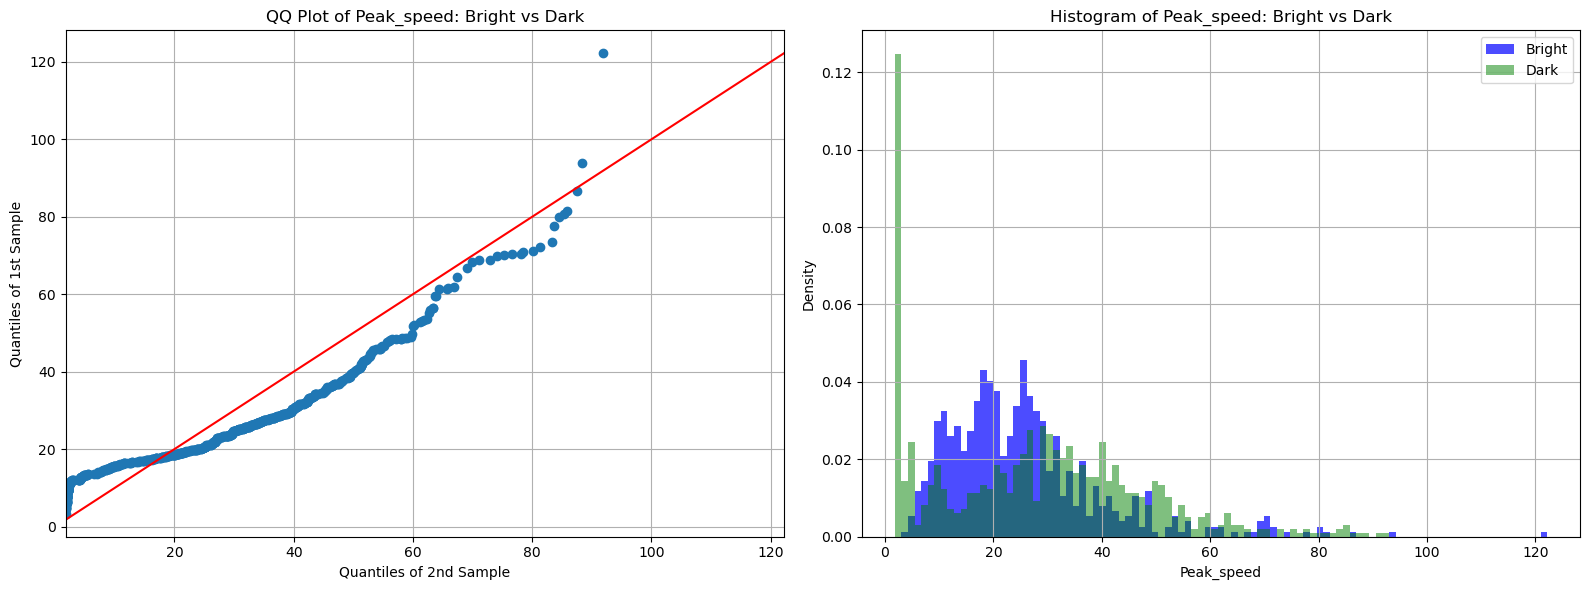

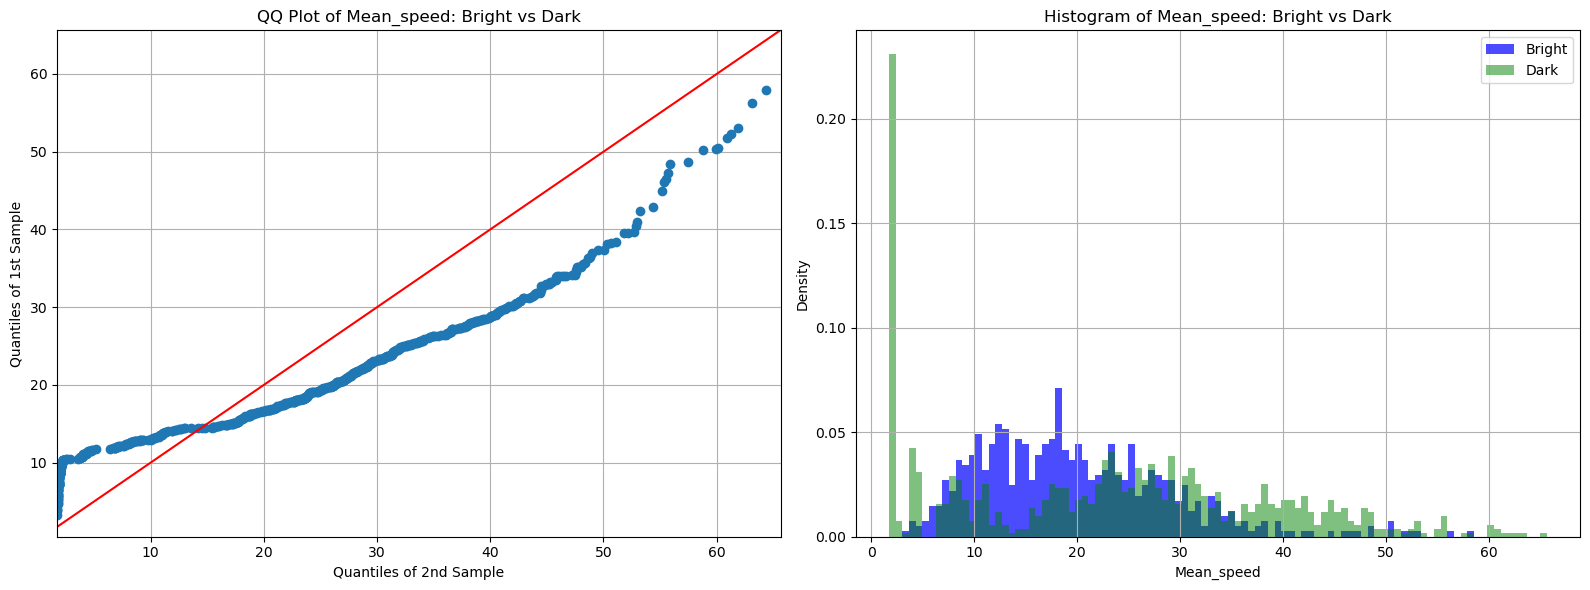

In [74]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_bright,
        bout_properties_df2=bout_properties_df_dark,
        label1='Bright',
        label2='Dark',
        column=column,
        bins=100
    )

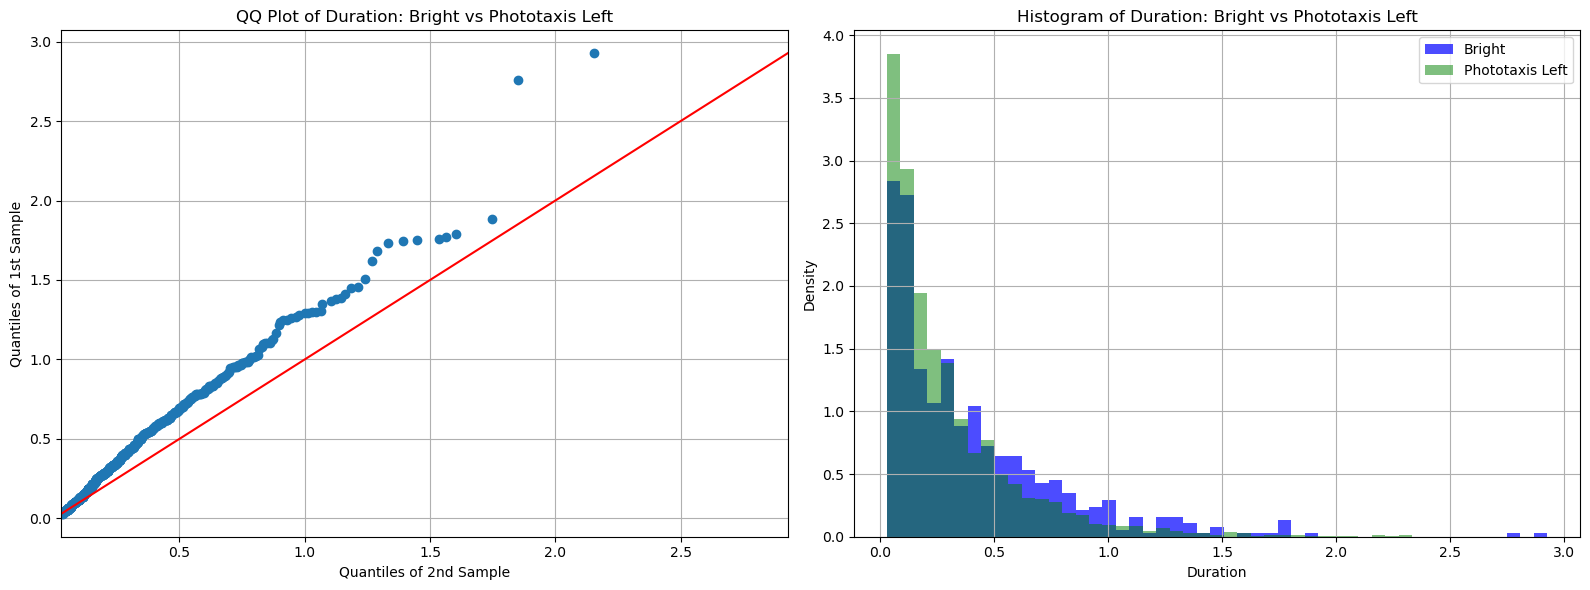

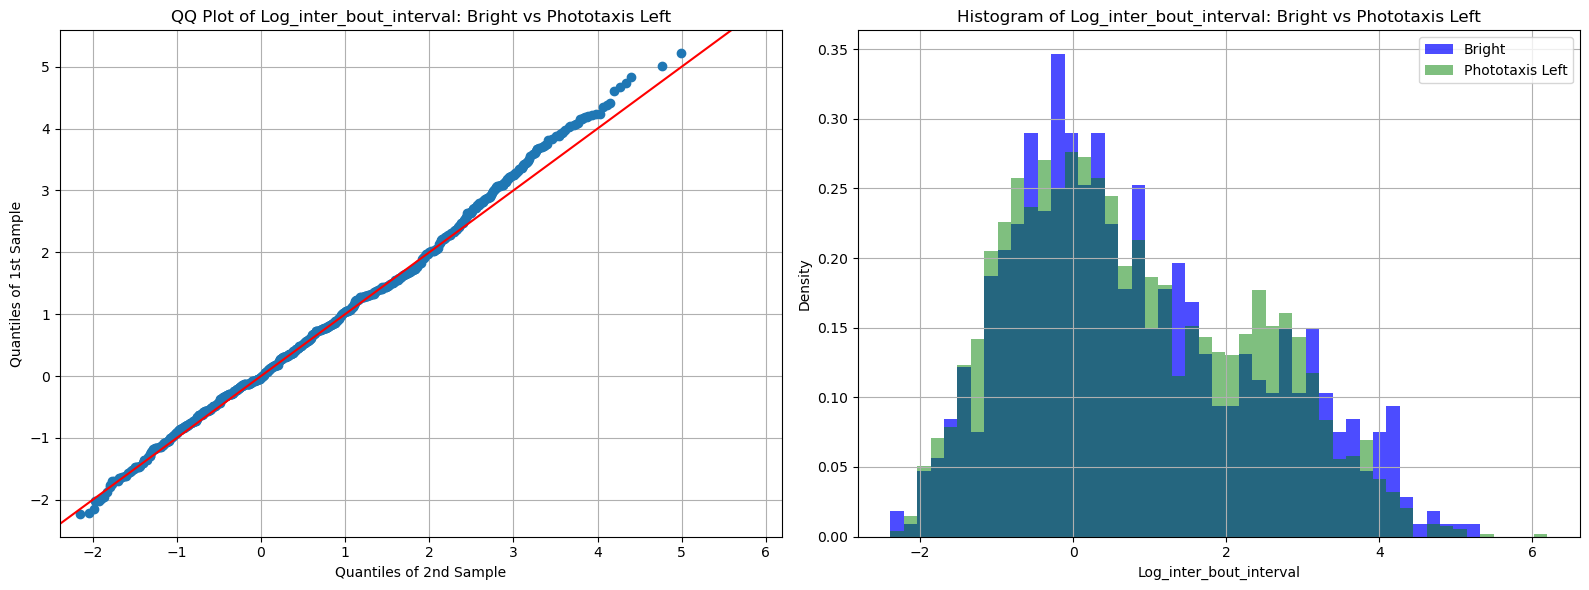

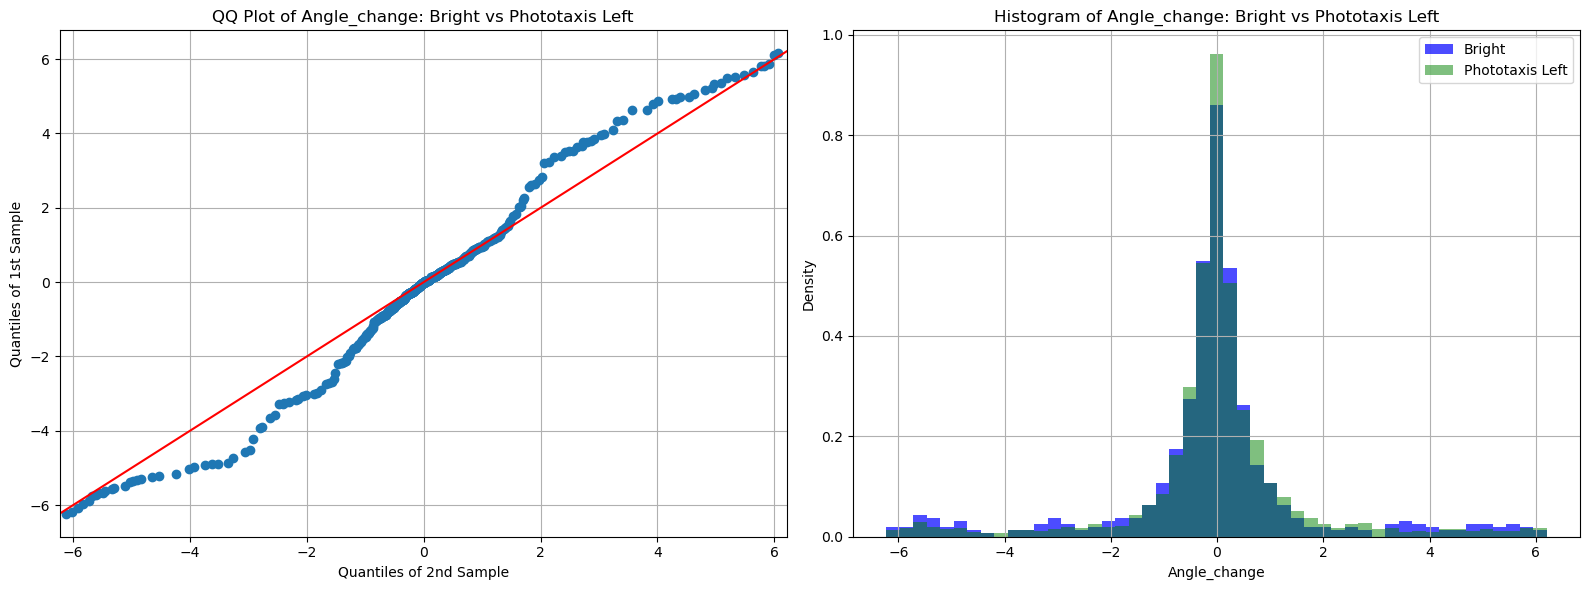

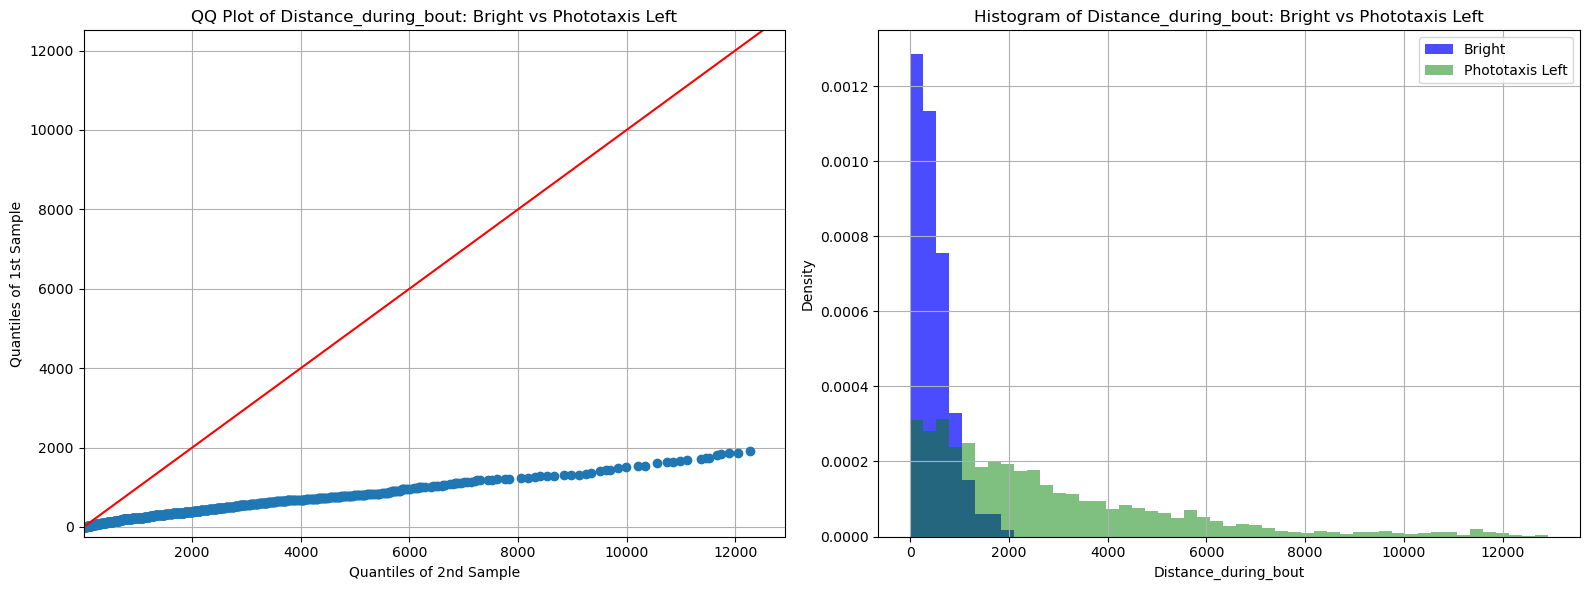

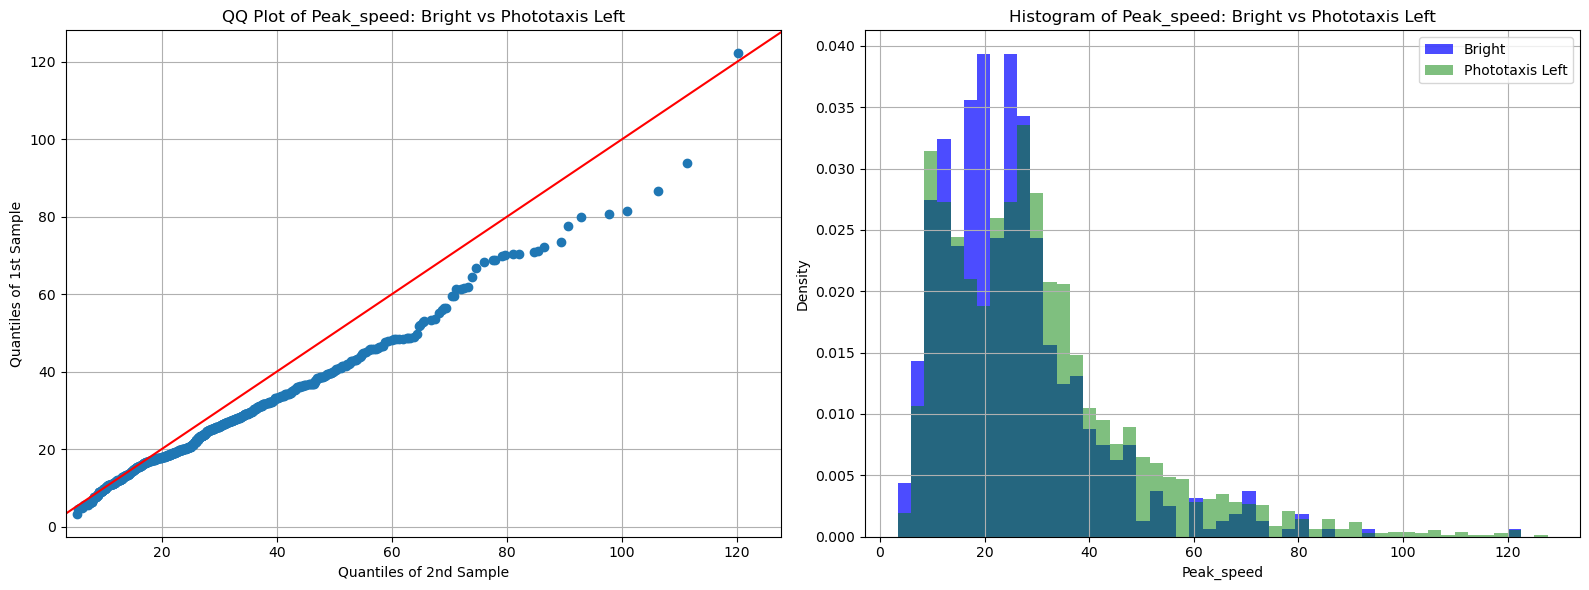

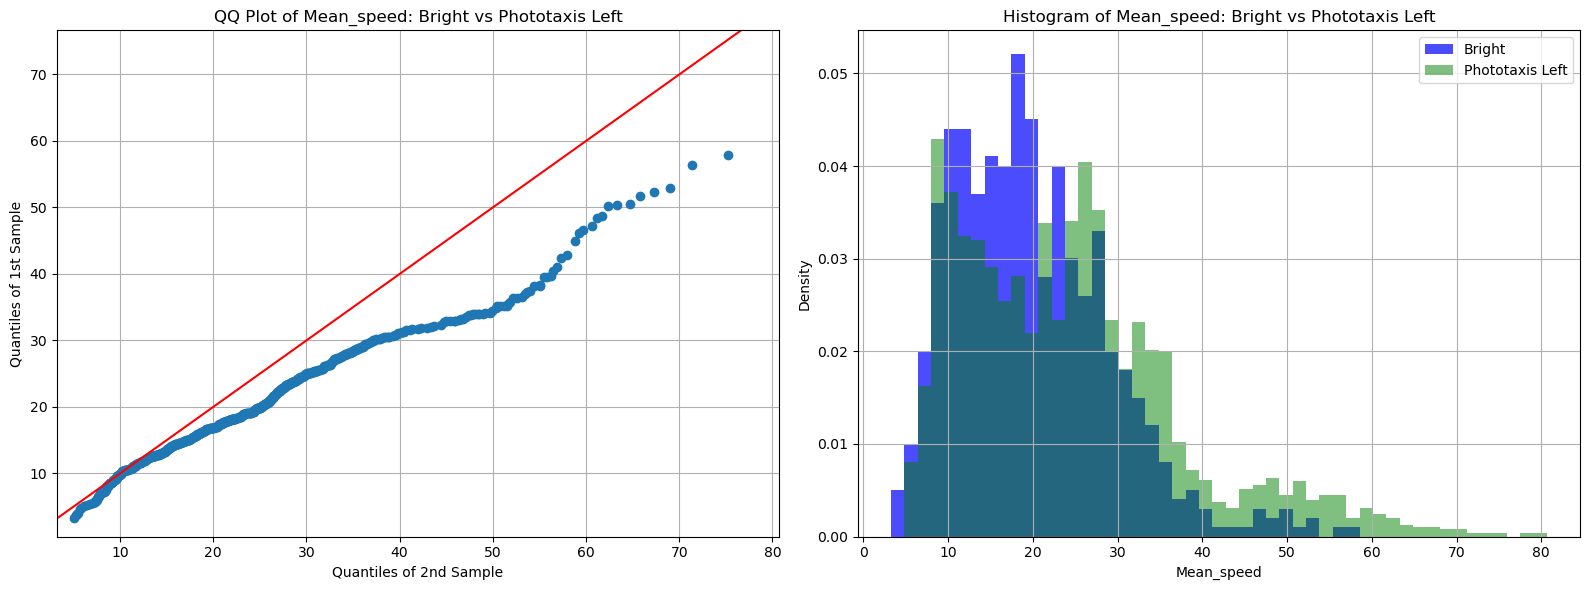

In [69]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_bright,
        bout_properties_df2=bout_properties_df_phototaxis_left,
        label1='Bright',
        label2='Phototaxis Left',
        column=column,
        bins=50
    )

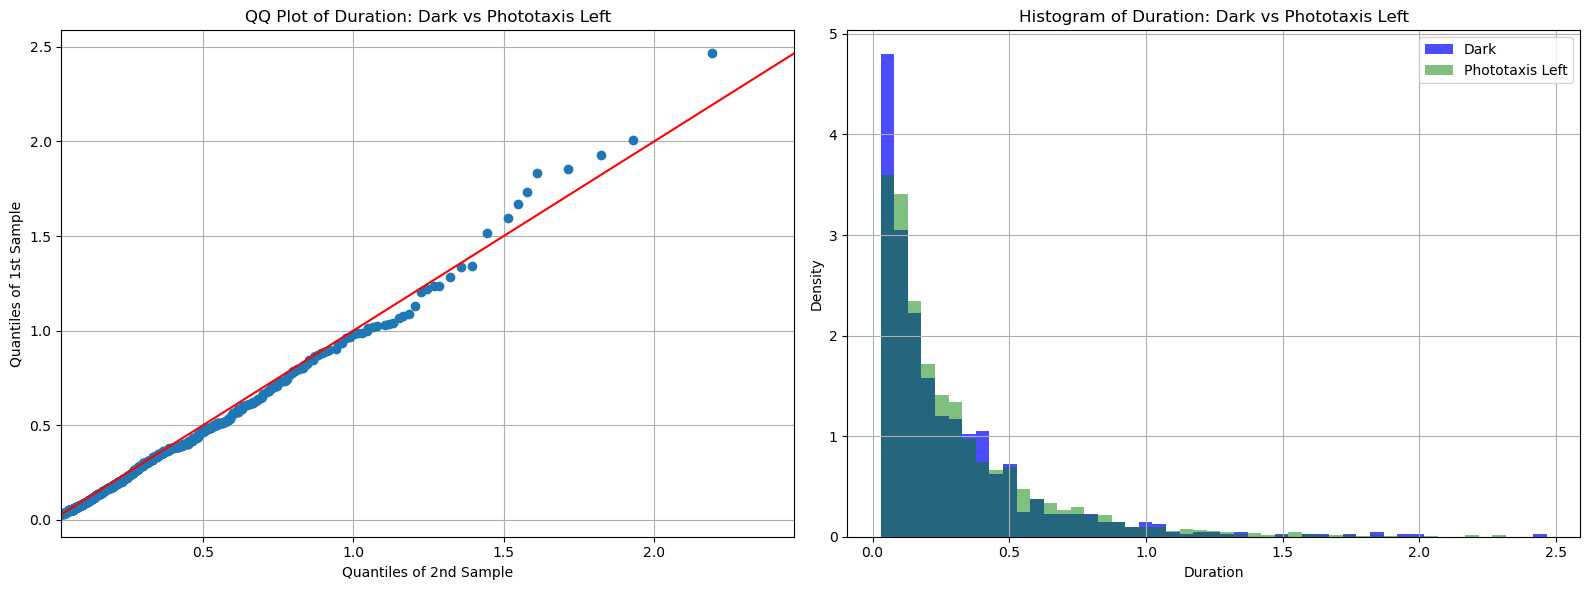

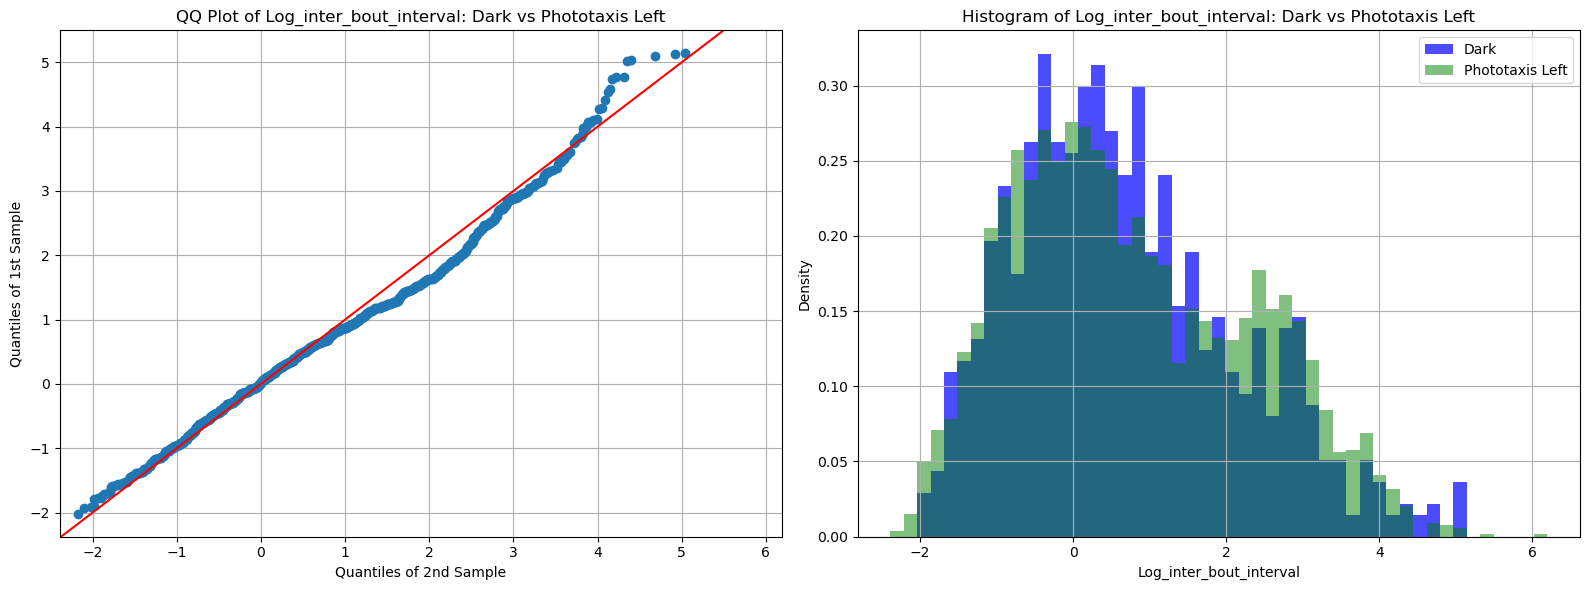

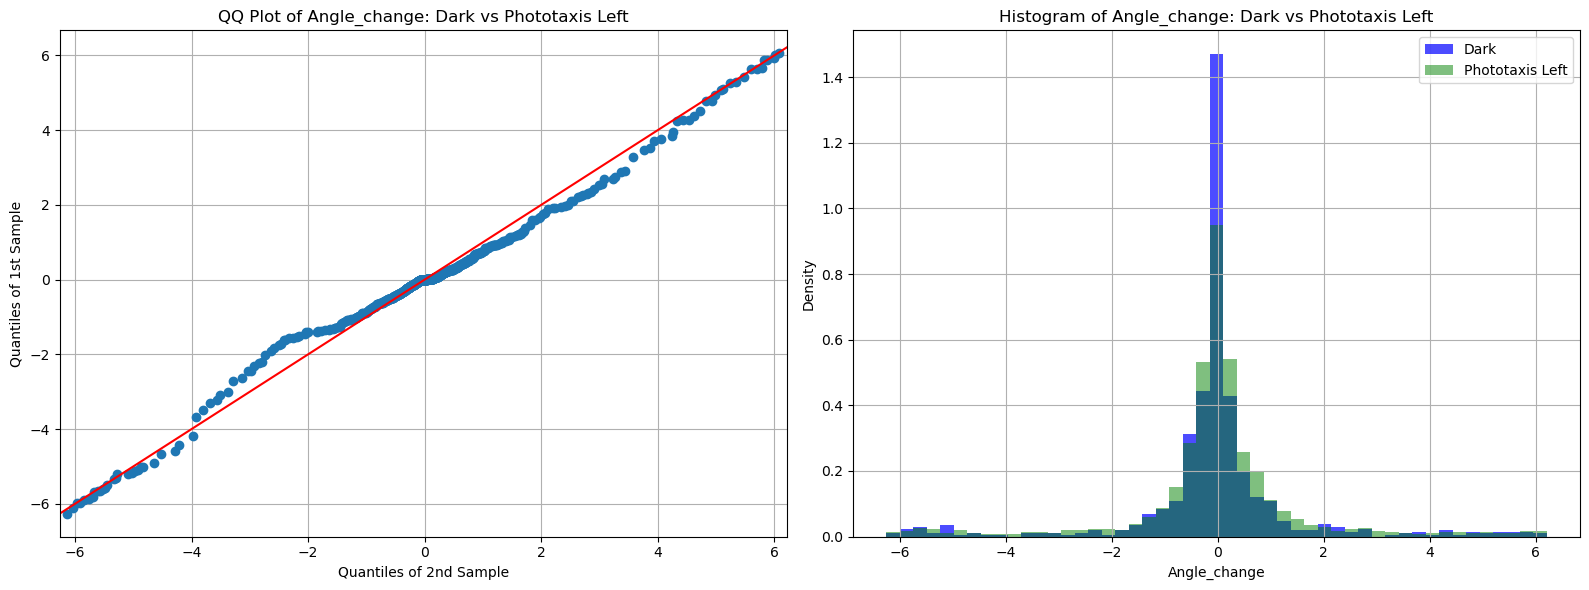

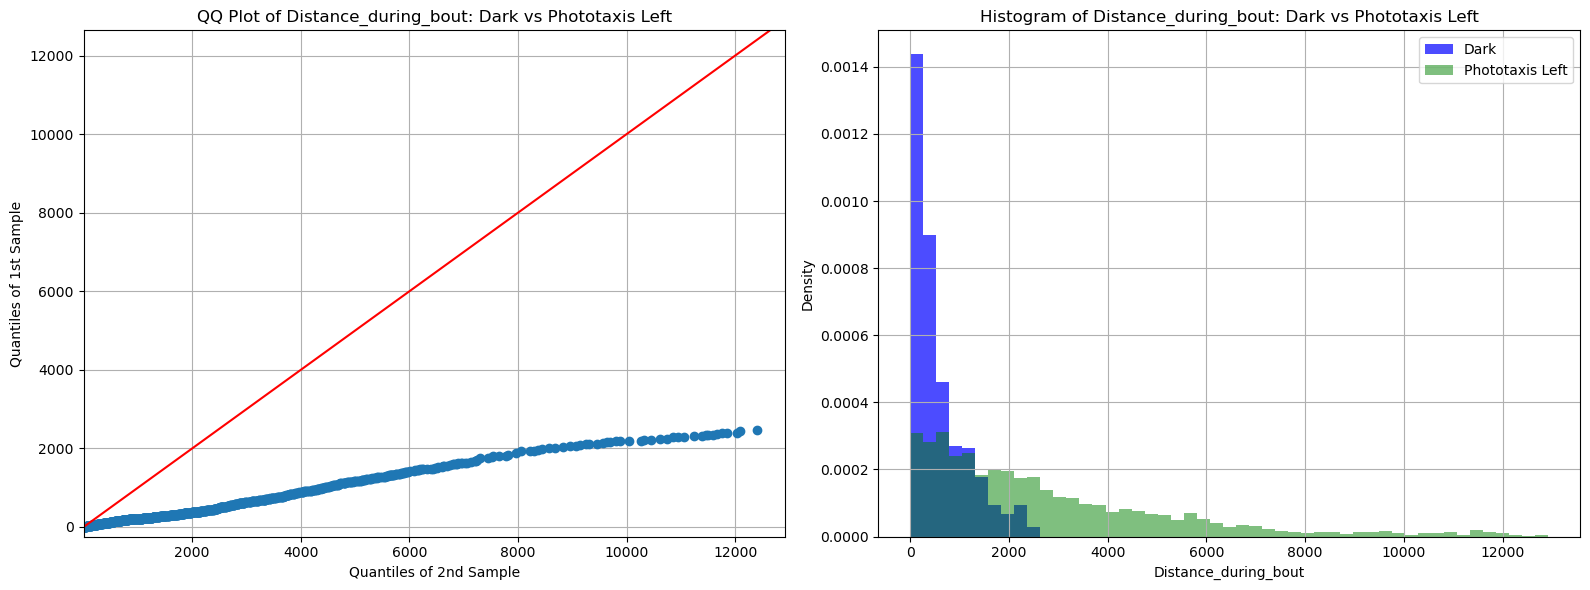

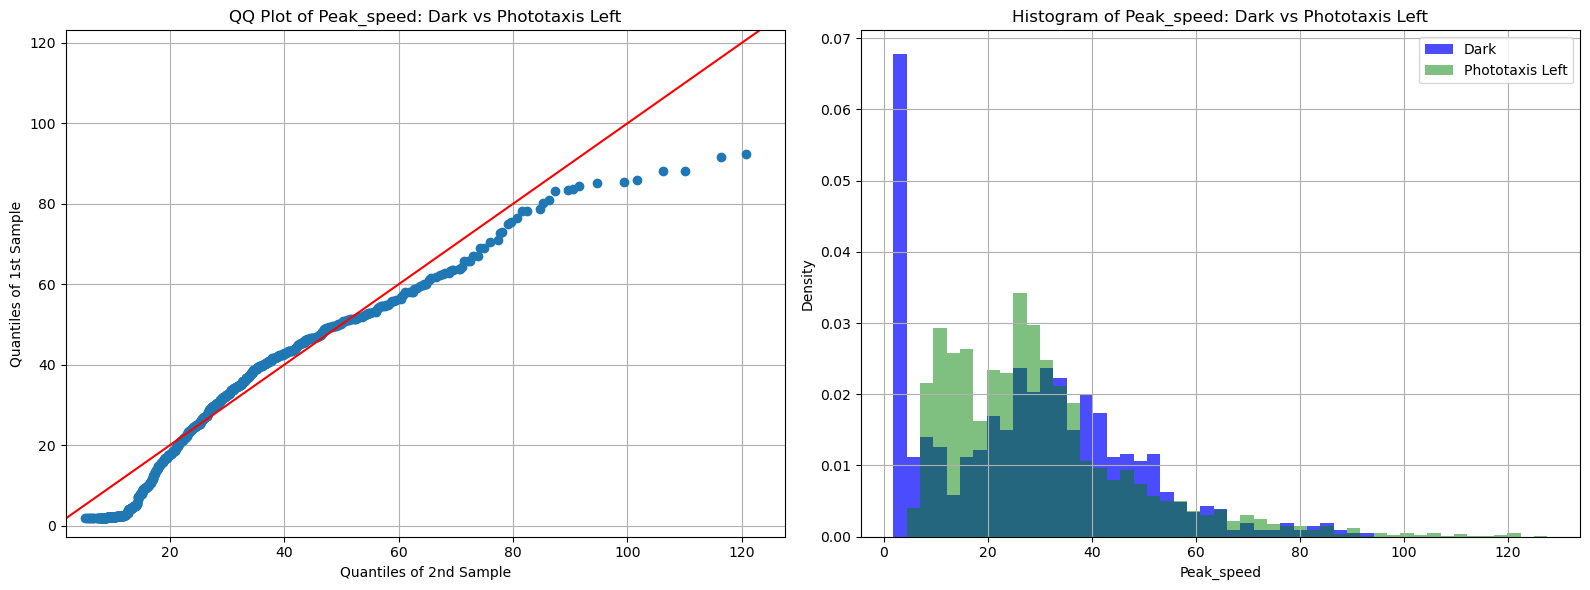

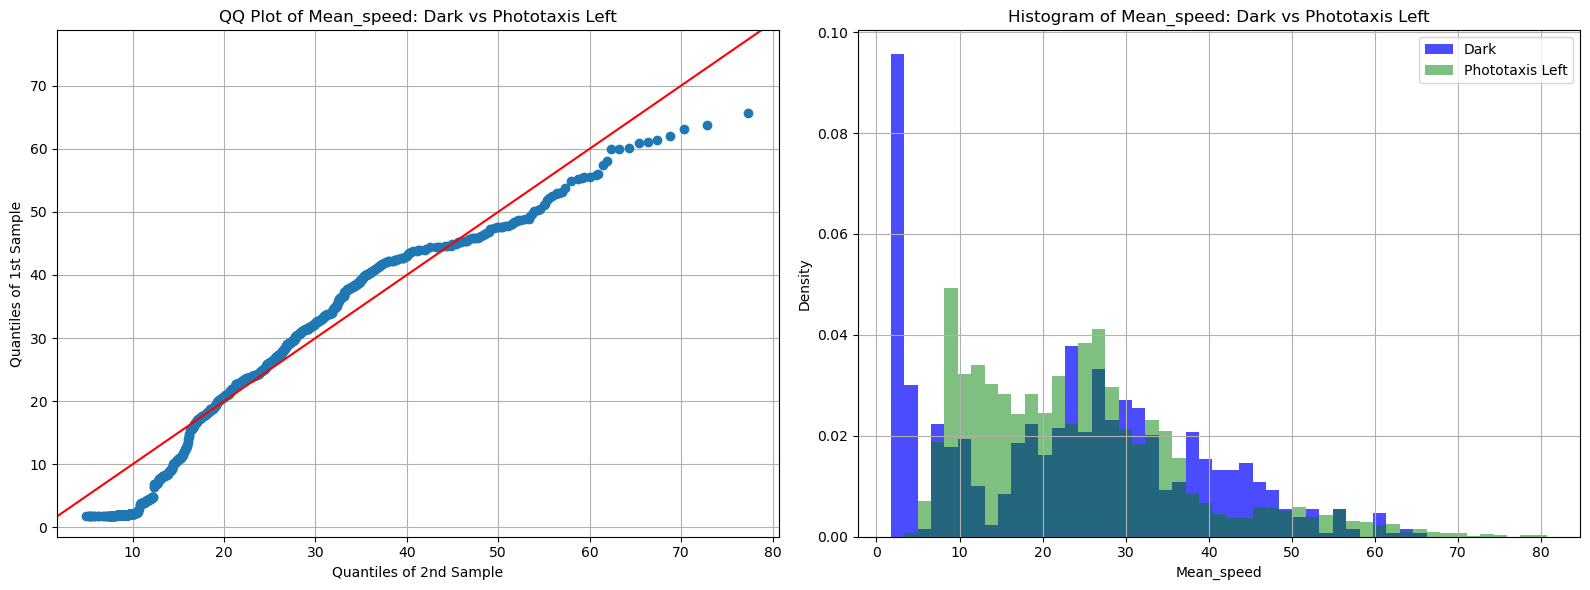

In [72]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_dark,
        bout_properties_df2=bout_properties_df_phototaxis_left,
        label1='Dark',
        label2='Phototaxis Left',
        column=column,
        bins=50
    )

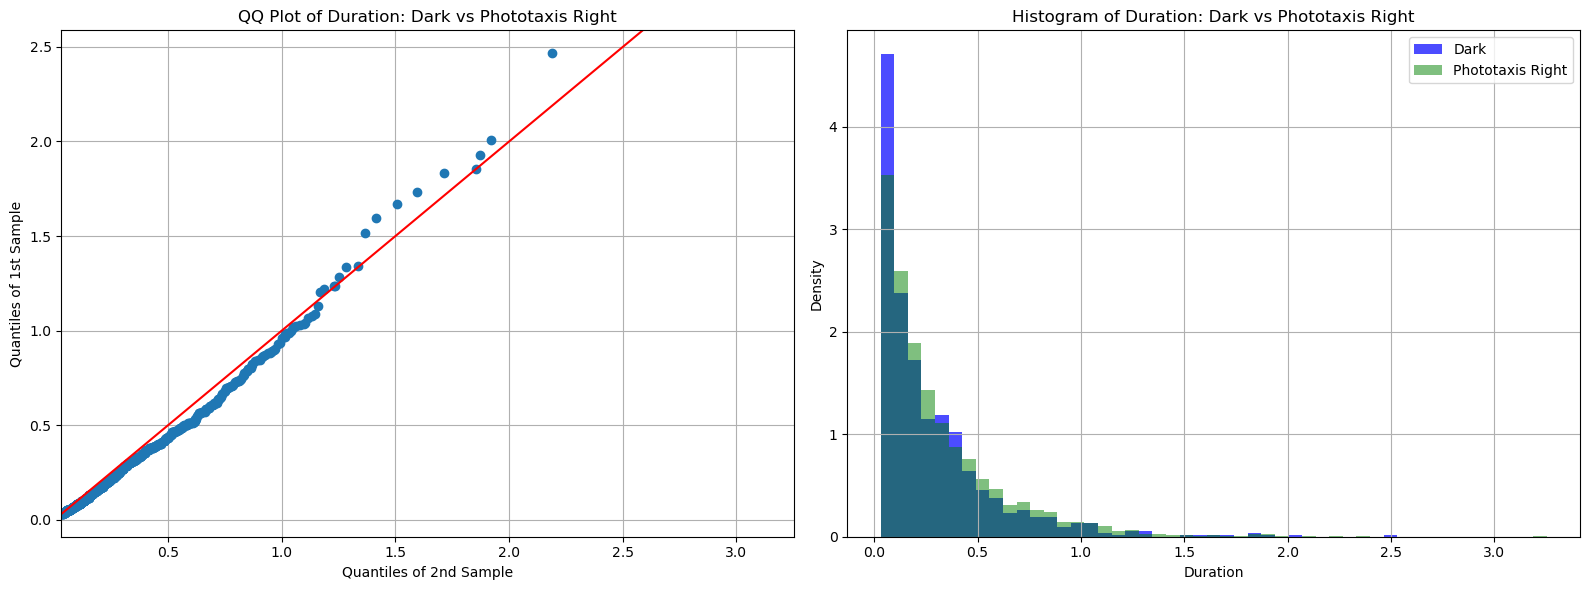

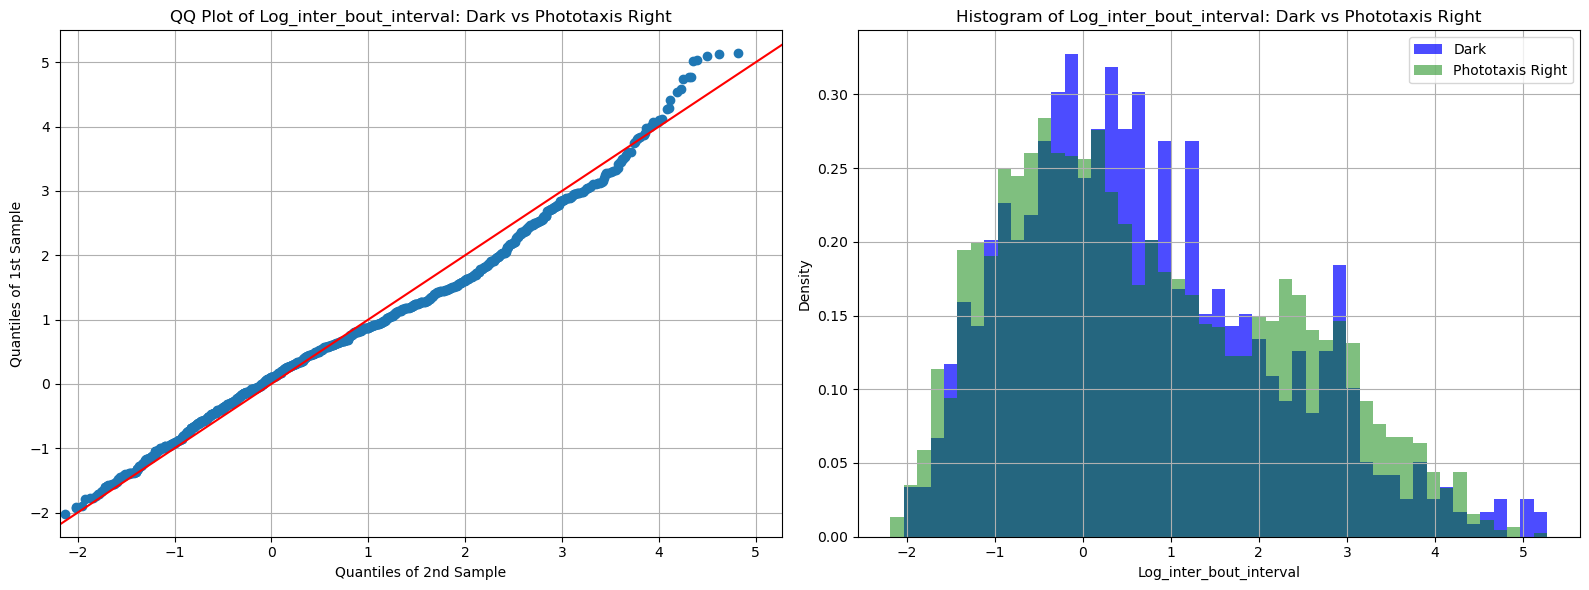

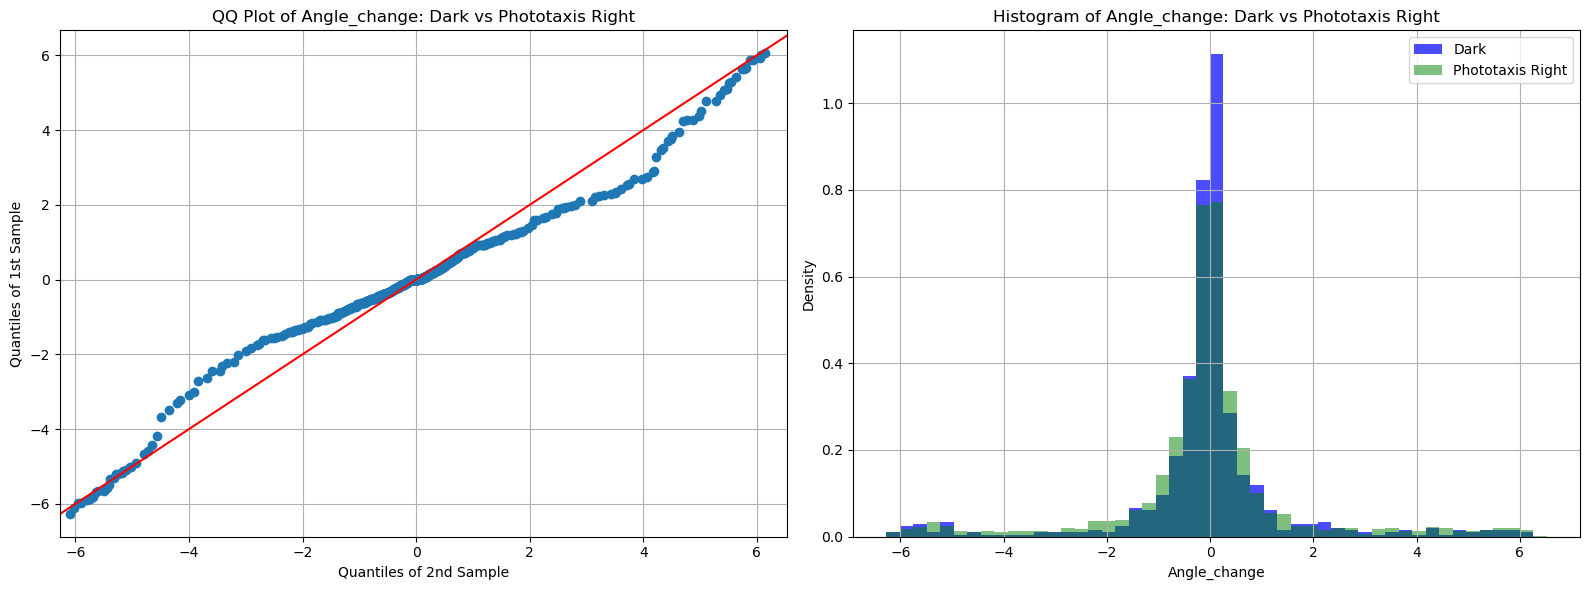

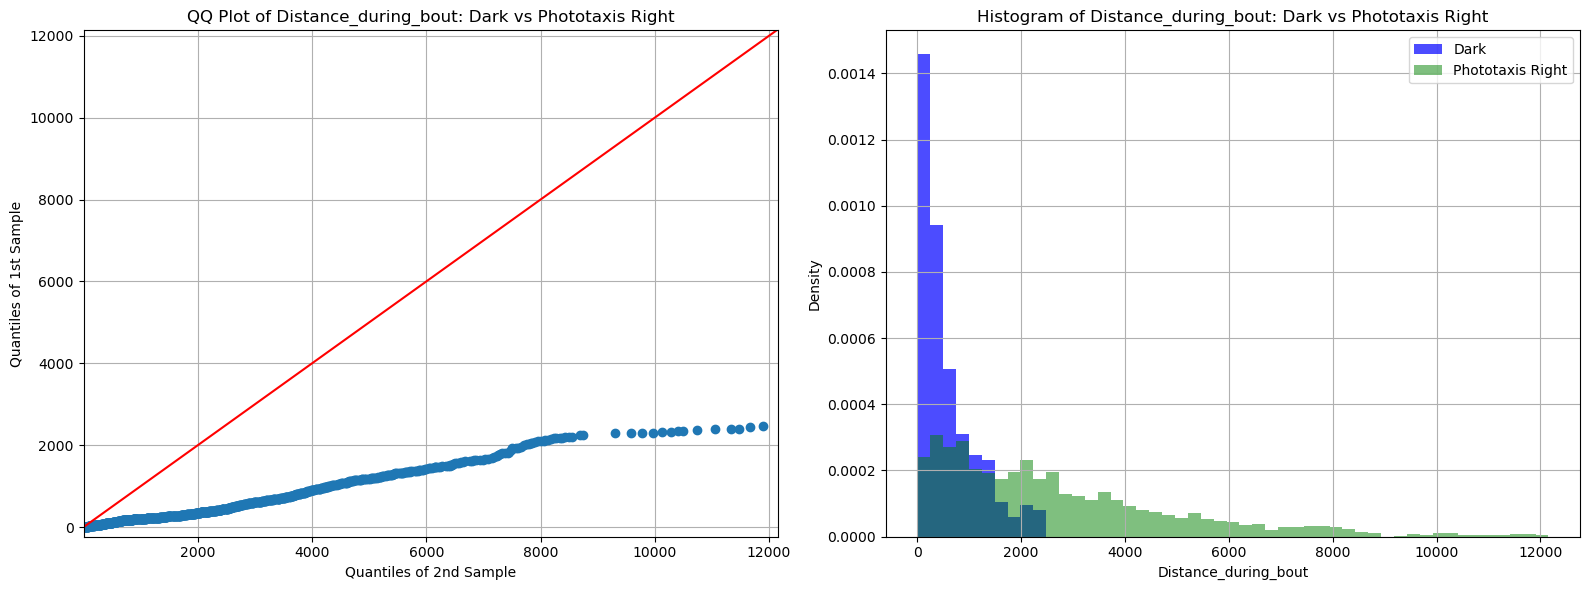

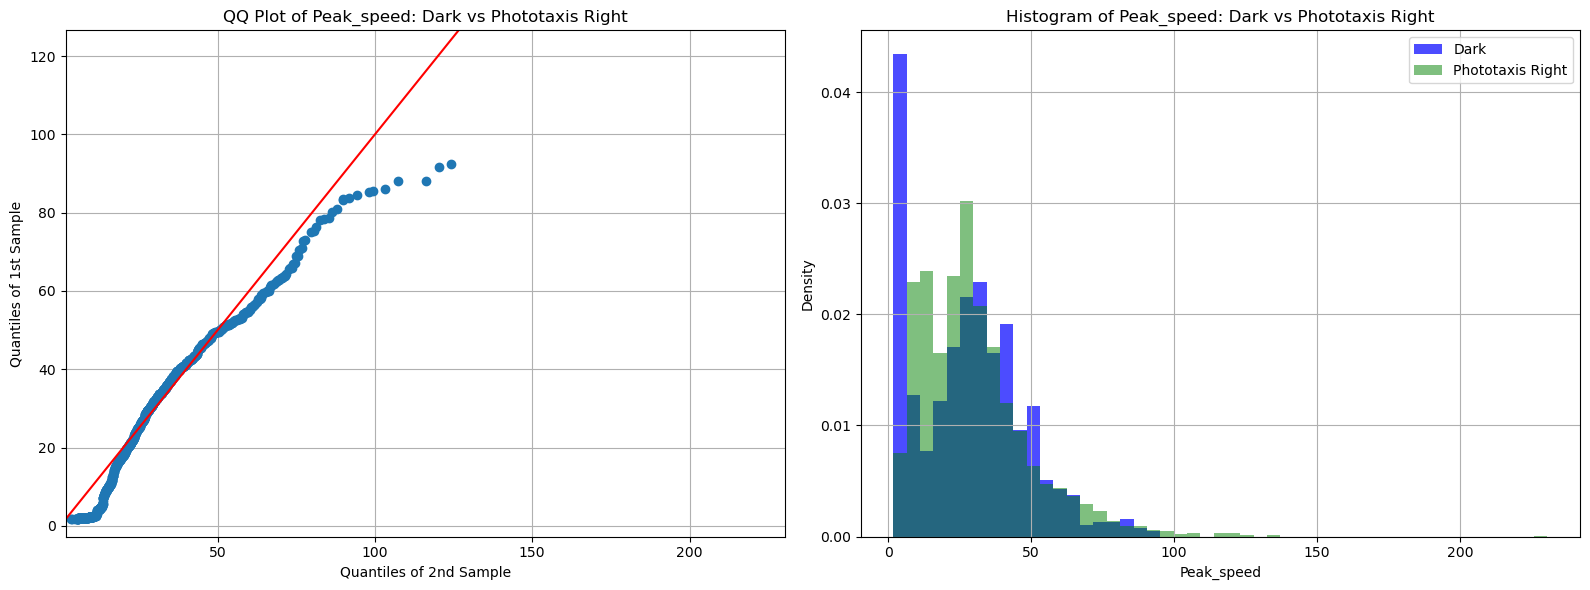

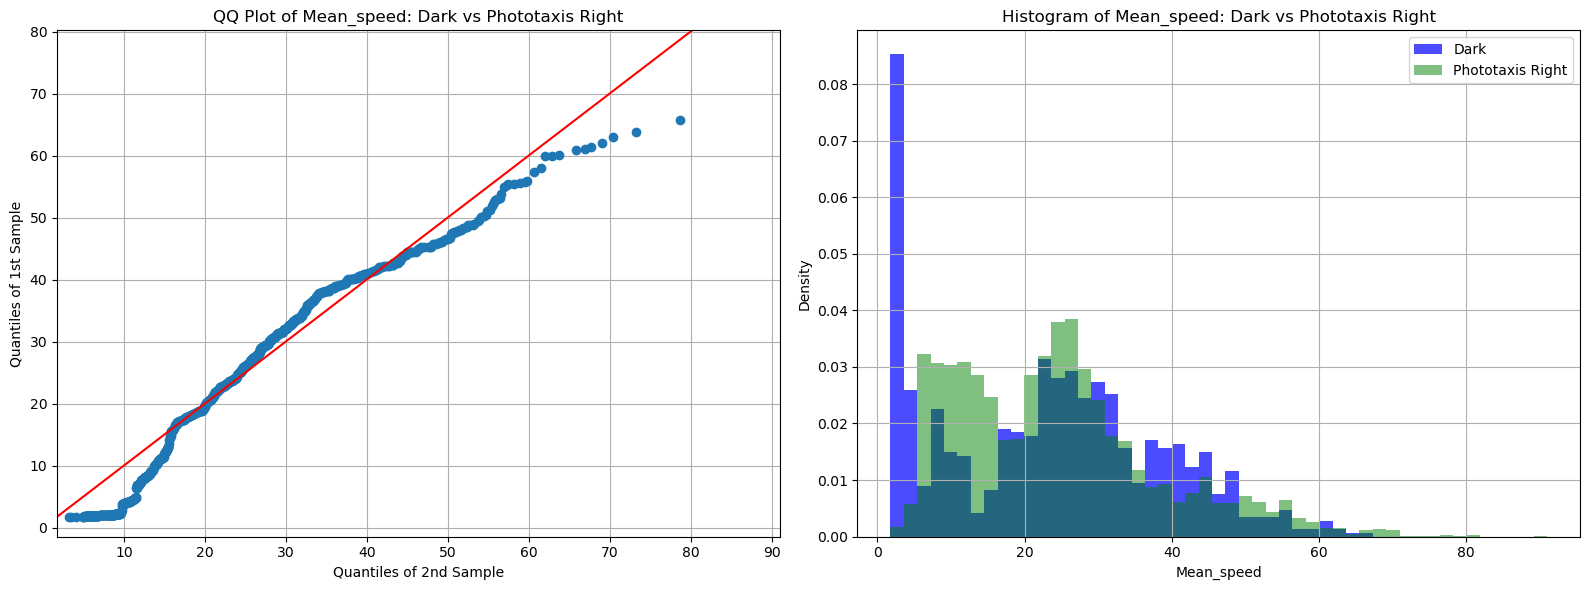

In [73]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_dark,
        bout_properties_df2=bout_properties_df_phototaxis_right,
        label1='Dark',
        label2='Phototaxis Right',
        column=column,
        bins=50
    )